# Main results

### $\mathrm{IB}$ attack. Characterization of the phase transition

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple

from robustness import logger
logger.setLevel('INFO')

from robustness import NETWORKS_DIR
from robustness.mpl_settings_v3 import *
from robustness.planar import create_proximity_graph
from robustness.auxiliary import (
    getLinearReg, 
    get_base_network_name, 
    powerlaw, 
    load_delta_data, 
    read_data_file
)
from robustness.plot_auxiliary import (
    letters,
    attack_dict,
    fig_dir, 
    load_delta,
    load_deltas,
    load_dataframe, 
    get_critical_measures,
    getPeaks,
    compute_fc_v2,
    get_rc_values,
    get_l_cutoff, 
    load_comp_sizes_data
)

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

marker_dict = {'meanS': 'o', 'Nsec': 's', 'varSgcc': '^', 'Sgcc': '*', 'num_over_denom': '>'}
color_dict = {'meanS': 'C0', 'Nsec': 'C1', 'varSgcc': 'C2', 'Sgcc': 'C3', 'num_over_denom': 'C4'}
linestyle_dict = {'meanS': '--', 'Nsec': '-.', 'varSgcc': ':', 'Sgcc': ':', 'num_over_denom': '--'}
measures_dict = {
    'meanS': r'$\langle s \rangle$', 'Nsec': r'$S_2 N$', 'varSgcc': r'$\chi$',
    'Sgcc': r'$N_1$', 'num_over_denom': r'$\langle s \rangle_{\mathrm{ens}}$', 'num': r'$M_2$'
}
line_colors = {'meanS': 'k', 'Nsec': 'grey', 'varSgcc': 'brown', 'Sgcc': 'C8', 'num_over_denom': 'C7'}

1024
2048
4096
8192
16384
32768
65536
131072


INFO: 06/16/2021 04:45:14 PM NumExpr defaulting to 4 threads.


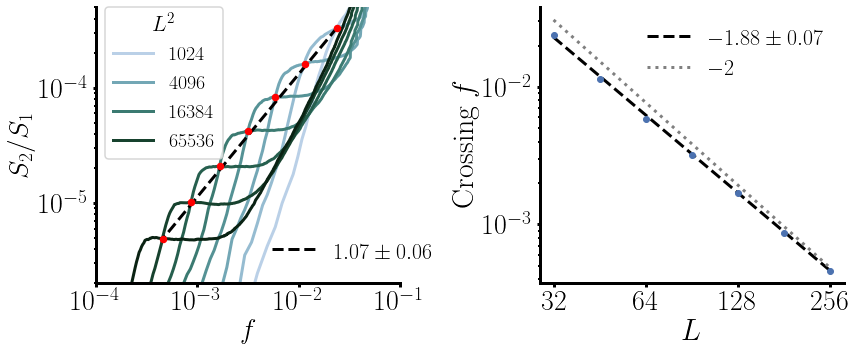

In [2]:
attack = 'Btw'
sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]  

dfs = {}
for N in sizes:
    try:
        print(N)
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        print(N)
        continue

N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colors = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, 
    light=0.8, dark=0.1
)

MIN = 1e-6
MAX = 1e-3
        
S2_over_S1 = {}
for N in N_values:
    df = dfs[N]        
    S1 = df.Sgcc
    S2 = df.Nsec / N
   
    S2_over_S1[N] = S2/S1
    
    mask = (S2_over_S1[N] < MIN) | (S2_over_S1[N] > MAX)
    S2_over_S1[N][mask] = np.NaN
    
cross_values = []
for N in sizes[:-1]:
    Na = N
    Nb = 2*N
    
    x = dfs[Nb].f.values
    
    xp = dfs[Na].f.values
    fp = S2_over_S1[Na]
    Na_values = np.interp(x, xp, fp)
    
    xp = dfs[Nb].f.values
    fp = S2_over_S1[Nb]
    Nb_values = np.interp(x, xp, fp)
    
    diff = Na_values - Nb_values
    #diff = S2_over_S1[Na].values - S2_over_S1[Nb].values

    argmax = np.argmax(diff>0)    
    cross_values.append((argmax/Nb, S2_over_S1[Nb][argmax]))
    
cross_values = np.array(cross_values)

fmin = 1e-4
fmax = 1e-1
ymin = 2e-6
ymax = 5e-4       

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_ylim(ymin, ymax)

ax.set_ylabel(r'$S_2/S_1$', fontsize=28)
ax.set_xlabel(r'$f$', fontsize=28)

for i, N in enumerate(N_values):
    L = np.sqrt(N)
    #ax.axvline(1/L**1.3, linestyle=':', color='gray')
    df = dfs[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    S2_over_S1 = df.Nsec / (N * df.Sgcc)
    label = r'${{{}}}$'.format(N) if i%2 == 0 else ''
    ax.plot(
        df.f[1:], S2_over_S1[1:], '-',
        color=colors[i], label=label)
    if N != N_values[-1]:
        ax.scatter(*cross_values[i], color='red', zorder=100)

X, Y = cross_values[:,0], cross_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
c = Y[-1] / X[-1]**slope
Y_pred = powerlaw(X, slope, c)
label = r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
ax.plot(X, Y_pred, '--', color='k', label=label)
        
#bbox = {'boxstyle': 'round', 'fc': 'None'}
#ax.text(0.04, 0.9, attack_dict[attack], fontsize=20, transform=ax.transAxes, bbox=bbox, 
#        horizontalalignment='left')


handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles[:-1], labels[:-1],
          fontsize=20, loc=(0.03, 0.45))
legend1.set_title(r'$L^2$', prop={'size':22})
ax.add_artist(legend1)
## Lines
ax.legend(handles[-1:], labels[-1:],
          fontsize=22, loc=(0.55, 0.05), frameon=False)

ax = axes[1]

X = np.sqrt(sizes[:-1])
Y = cross_values[:,0]
Y_pred, slope, y_err = getLinearReg(X, Y)
c = Y[-1] / X[-1]**slope
Y_pred = powerlaw(X, slope, c)

label = r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
ax.plot(X, Y_pred, '--', color='k', label=label)

label = r'$-2$'
ax.plot(X, powerlaw(X, -2, 2*c), ':', color='grey', label=label)
ax.plot(X, Y, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([32, 64, 128, 256])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathrm{Crossing}\; f$')
ax.legend(fontsize=22, frameon=False)

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'crossing_method_B_' + net_type)
plt.savefig(fig_name + '.png', transparent=False)
plt.savefig(fig_name + '.pdf')

plt.show()

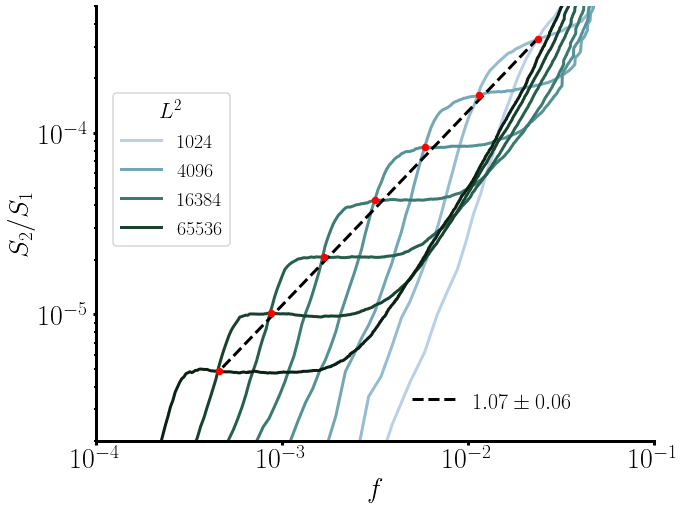

In [19]:
attack = 'Btw'
sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]  

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        print(N)
        continue

N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colors = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, 
    light=0.8, dark=0.1
)

MIN = 1e-6
MAX = 1e-3
        
S2_over_S1 = {}
for N in N_values:
    df = dfs[N]        
    S1 = df.Sgcc
    S2 = df.Nsec / N
   
    S2_over_S1[N] = S2/S1
    
    mask = (S2_over_S1[N] < MIN) | (S2_over_S1[N] > MAX)
    S2_over_S1[N][mask] = np.NaN
    
cross_values = []
for N in sizes[:-1]:
    Na = N
    Nb = 2*N
    
    x = dfs[Nb].f.values
    
    xp = dfs[Na].f.values
    fp = S2_over_S1[Na]
    Na_values = np.interp(x, xp, fp)
    
    xp = dfs[Nb].f.values
    fp = S2_over_S1[Nb]
    Nb_values = np.interp(x, xp, fp)
    
    diff = Na_values - Nb_values
    #diff = S2_over_S1[Na].values - S2_over_S1[Nb].values

    argmax = np.argmax(diff>0)    
    cross_values.append((argmax/Nb, S2_over_S1[Nb][argmax]))
    
cross_values = np.array(cross_values)

fmin = 1e-4
fmax = 1e-1
ymin = 2e-6
ymax = 5e-4       

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_ylim(ymin, ymax)

ax.set_ylabel(r'$S_2/S_1$', fontsize=28)
ax.set_xlabel(r'$f$', fontsize=28)

for i, N in enumerate(N_values):
    L = np.sqrt(N)
    #ax.axvline(1/L**1.3, linestyle=':', color='gray')
    df = dfs[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    S2_over_S1 = df.Nsec / (N * df.Sgcc)
    label = r'${{{}}}$'.format(N) if i%2 == 0 else ''
    ax.plot(
        df.f[1:], S2_over_S1[1:], '-',
        color=colors[i], label=label)
    if N != N_values[-1]:
        ax.scatter(*cross_values[i], color='red', zorder=100)

X, Y = cross_values[:,0], cross_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
c = Y[-1] / X[-1]**slope
Y_pred = powerlaw(X, slope, c)
label = r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
ax.plot(X, Y_pred, '--', color='k', label=label)
        
handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles[:-1], labels[:-1],
          fontsize=20, loc=(0.03, 0.45))
legend1.set_title(r'$L^2$', prop={'size':22})
ax.add_artist(legend1)
## Lines
ax.legend(handles[-1:], labels[-1:],
          fontsize=22, loc=(0.55, 0.05), frameon=False)

sns.despine()

plt.show()

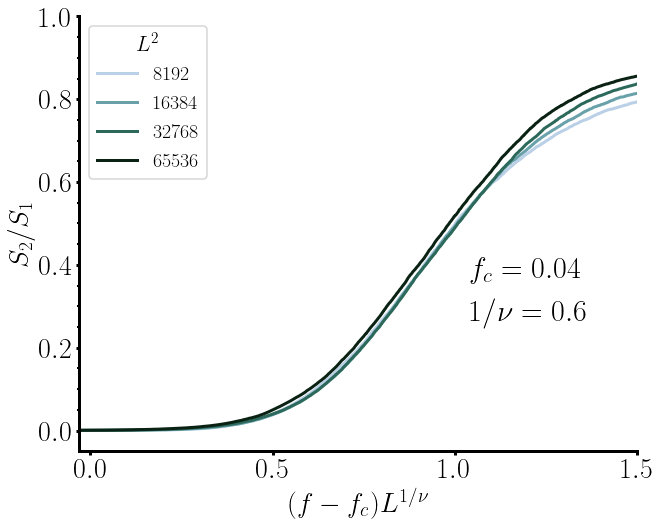

In [63]:
attack = 'Btw'
sizes = [
    #Ç2048, 4096, 
    8192, 16384, 32768, 65536,# 131072#, 262144
]  

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        print(N)
        continue

N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colors = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, 
    light=0.8, dark=0.1
)

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

one_over_nu = 0.6

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(-0.03, 1.5)
ax.set_ylim(-0.05, 1)
fc = 0.04
ax.set_ylabel(r'$S_2/S_1$', fontsize=28)
ax.set_xlabel(r'$(f-f_c)L^{1/\nu}$', fontsize=28)

for i, N in enumerate(N_values):
    L = np.sqrt(N)
    #ax.axvline(1/L**1.3, linestyle=':', color='gray')
    df = dfs[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    S2_over_S1 = df.Nsec / (N * df.Sgcc)
    binder_cum = df.meanS / (N * df.Sgcc**2)
    #binder_cum = df.meanS / N
    label = r'${{{}}}$'.format(N) #if i%2 == 0 else ''
    ax.plot(
        (df.f-fc)*L**one_over_nu, 
        S2_over_S1, 
        #binder_cum[1:],
        '-',
        color=colors[i], label=label)
ax.text(0.7, 0.4, r'$f_c = {{{}}}$'.format(fc),transform=ax.transAxes, fontsize=30)
ax.text(0.7, 0.3, r'$1/\nu= {{{}}}$'.format(one_over_nu),transform=ax.transAxes, fontsize=30)

handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles, labels,
          fontsize=20, loc='best')
legend1.set_title(r'$L^2$', prop={'size':22})
sns.despine()

plt.show()

In [ ]:
attack = 'Btw'
sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]  

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        print(N)
        continue

N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colors = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, 
    light=0.8, dark=0.1
)

MIN = 1e-6
MAX = 1e-3
        
S2_over_S1 = {}
for N in N_values:
    df = dfs[N]        
    S1 = df.Sgcc
    S2 = df.Nsec / N
   
    S2_over_S1[N] = S2/S1
    
    mask = (S2_over_S1[N] < MIN) | (S2_over_S1[N] > MAX)
    S2_over_S1[N][mask] = np.NaN
    
cross_values = []
for N in sizes[:-1]:
    Na = N
    Nb = 2*N
    
    x = dfs[Nb].f.values
    
    xp = dfs[Na].f.values
    fp = S2_over_S1[Na]
    Na_values = np.interp(x, xp, fp)
    
    xp = dfs[Nb].f.values
    fp = S2_over_S1[Nb]
    Nb_values = np.interp(x, xp, fp)
    
    diff = Na_values - Nb_values

    argmax = np.argmax(diff>0)    
    cross_values.append((argmax/Nb, S2_over_S1[Nb][argmax]))
    
cross_values = np.array(cross_values)
   

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax = ax
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.axhline(1)
ax.set_xlim(5e-2, 1)
#ax.set_ylim(ymin, ymax)

#ax.set_ylabel(r'$S_2/S_1L^{2\alpha}$', fontsize=28)
#ax.set_xlabel(r'$fL^{2\alpha}$', fontsize=28)

alpha = 1.
for i, N in enumerate(N_values):
    L = np.sqrt(N)
    df = dfs[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    S2_over_S1 = df.Nsec / (N * df.Sgcc)
    label = r'${{{}}}$'.format(N) if i%2 == 0 else ''
    ax.plot(
        #df.f[1:]*L**(2*alpha), 
        df.f[1:]*L**0.6,
        S2_over_S1[1:],#*L**(2*alpha), 
        '-',
        color=colors[i], label=label
    )
    if N != N_values[-1]:
        x, y = cross_values[i]
        ax.scatter(x*L**(2*alpha), y*L**(2*alpha), color='red', zorder=100)
    text = r'$\alpha = {{{}}}$'.format(alpha)
    ax.text(0.3, 0.05, text, transform=ax.transAxes)
handles, labels = ax.get_legend_handles_labels()
## Markers
legend = ax.legend(fontsize=20, loc='best')
legend.set_title(r'$L^2$', prop={'size':22})

plt.show()

In [7]:
measures = ['meanS', 'Nsec', 'varSgcc', 'num_over_denom']
attacks = ['Btw']

sizes = [
    #1024, 2048,
    #4096, 8192, 16384, 
    32768, 65536, 131072
]
print('attack\t          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max')

data = {}
for k, attack in enumerate(attacks):
    
    data[attack] = {}
    
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
        except FileNotFoundError:
            continue
    N_values = np.array(list(dfs.keys()))
    L_values = np.sqrt(N_values)
        
    for i, measure in enumerate(measures):
        
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
        
        if measure == 'Nsec':
            beta_over_nu = 2 - slope
            delta_beta = y_err
        elif measure in ['meanS', 'varSgcc']:
            gamma_over_nu = slope
            delta_gamma = y_err    
            
            
        data[attack][measure] = [L_values, measure_values, Y_pred, slope, y_err]
            
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_nu/(beta_over_nu+gamma_over_nu)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    
    nu = 4/3
    print(
        '{:10}\t{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:10.4f}{:10.0f}'.format(
        attack, beta_over_nu, beta_over_nu*nu, gamma_over_nu, gamma_over_nu*nu,
        2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau, np.max(N_values)
        )
    )

attack	          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max
Btw       	   0.0147   0.0196   2.0258   2.7010   2.0552   0.0483   2.0072    0.0445    131072


IndexError: list index out of range

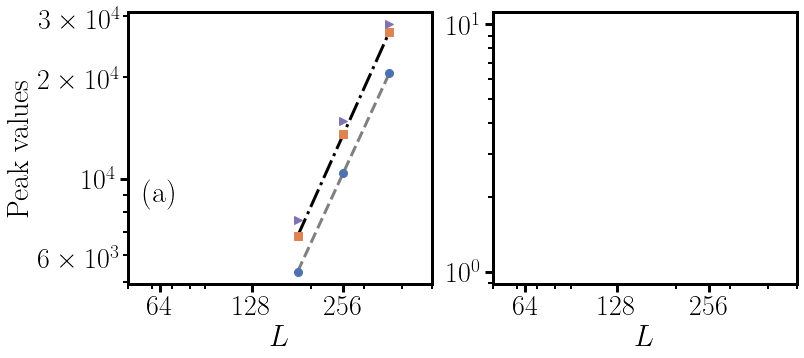

In [9]:
attack = 'Btw'
measures = [
    'meanS', 'Nsec', 
    #'varSgcc'
    'num_over_denom'
]

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlim(56, 340)
    #ax.set_xticks([64, 128, 256])
    ax.set_xlim(50, 500)
    ax.set_xticks([64, 128, 256])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]

ax.text(0.05, 0.3, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):

    L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    
    c = measure_values[-1] / L_values[-1]**slope
    if measure in ['meanS', 'varSgcc']:
        label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
        label1 = label
        #line1, = ax.plot(L_values, Y_pred, '--', color='grey', label=label)
        line1, = ax.plot(L_values, powerlaw(L_values, slope, c), '--', color='grey', label=label)


    elif measure == 'Nsec':
        label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
        label2 = label
        line2, = ax.plot(L_values, powerlaw(L_values, slope, c), '-.', color='k', label=label)            

    markers1, = ax.plot(
        L_values, measure_values, marker_dict[measure], 
        color=color_dict[measure], markersize=8, 
        label=measures_dict[measure]
    )

handles, labels = ax.get_legend_handles_labels()
## Markers
order = [1, 3, 5][:len(measures)]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.6, 0.05))

ax.add_artist(legend1)
## Lines
order = [2, 0, 4][:len(measures)]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.0, 0.73), frameon=False)

#########################################################

dfs = {}
for N in sizes:
    print(N)
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

ax = axes[1]
fc = 0.04
ax.text(0.05, 0.3, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$f_c(L)-f_c$')
for i, measure in enumerate(measures):
        
    X = L_values
    Y, _ = getPeaks(dfs, measure)
    print(Y)
    Y = np.array(Y) - fc
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[-1] / X[-1]**slope
    label = r'$1/\nu = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(-slope, 100*y_err)
    #ax.plot(X, Y_pred, linestyle_dict[measure], color=line_colors[measure], label=label)
    ax.plot(X, powerlaw(X, slope, c), linestyle_dict[measure], color=line_colors[measure], label=label)
    ax.plot(X, Y, marker_dict[measure], markersize=8, label=measures_dict[measure])
    
handles, labels = ax.get_legend_handles_labels()

## Lines
order = [0, 2, 4][:len(measures)]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.25, 0.73), frameon=False)

#ax.set_ylim(0.07, 0.13)
#ax.set_yticks([0.08, 0.1, 0.12])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.text(0.05, 0.1, r'$f_c={{{}}}$'.format(fc), fontsize=26, transform=ax.transAxes)    

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'beta_gamma_nu_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

4096
8192
16384
32768
65536
131072
[0.107177734375, 0.095458984375, 0.08502197265625, 0.076812744140625, 0.0685882568359375, 0.06230926513671875]


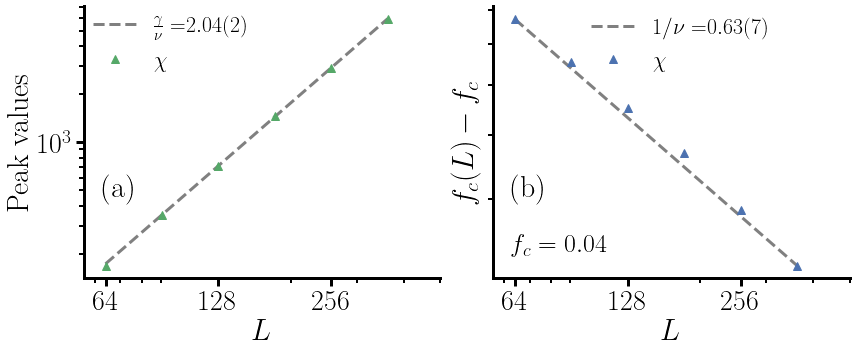

In [99]:
attack = 'Btw'
measures = ['varSgcc']

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(56, 500)
    ax.set_xticks([64, 128, 256])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]

ax.text(0.05, 0.3, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):

    L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    
    c = Y_pred[-1] / L_values[-1]**slope
    if measure in ['meanS', 'varSgcc']:
        label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
        label1 = label
        line1, = ax.plot(L_values, powerlaw(X, slope, c), '--', color='grey', label=label)   

    markers1, = ax.plot(
        L_values, measure_values, marker_dict[measure], 
        color=color_dict[measure], markersize=8, 
        label=measures_dict[measure]
    )
ax.legend(fontsize=22, loc=(0.0, 0.73), frameon=False)

#########################################################

dfs = {}
for N in sizes:
    print(N)
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

ax = axes[1]
fc = 0.04
ax.text(0.05, 0.3, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$f_c(L)-f_c$')
for i, measure in enumerate(measures):
        
    X = L_values
    Y, _ = getPeaks(dfs, measure)
    print(Y)
    Y = np.array(Y) - fc
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[-1] / X[-1]**slope
    label = r'$1/\nu = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(-slope, 100*y_err)
    ax.plot(X, powerlaw(X, slope, c), '--', color='grey', label=label)
    ax.plot(X, Y, marker_dict[measure], markersize=8, label=measures_dict[measure])
ax.legend(fontsize=22, loc=(0.25, 0.73), frameon=False)

#ax.set_ylim(0.07, 0.13)
#ax.set_yticks([0.08, 0.1, 0.12])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.text(0.05, 0.1, r'$f_c={{{}}}$'.format(fc), fontsize=26, transform=ax.transAxes)    

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'chi_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [5]:
attack = 'Btw'

sizes = np.array([
    #256, 512, 
    #1024, 2048, 4096, 
    #8192, 16384, 32768, 65536,
    131072#, 262144
])
all_mean_values = []
lower_mean_values = []
upper_mean_values = []
lower_std_values = []
upper_std_values = []
all_std_values = []
nseeds_values = []
fluctuations = {}
datas = {}
for i, N in enumerate(sizes):
    try:
        delta_data, nseeds = load_delta(
            net_type, N, param, attack, min_nseeds=10, return_nseeds=True
    )
    except FileNotFoundError:
        print(N)
        raise
    datas[N] = np.array(delta_data)
    nseeds_values.append(nseeds)
    
    delta_data[:,2] = delta_data[:,2]*N
    df = pd.DataFrame(delta_data, columns=['rc', 'delta', 'N1'])
    
    mean_values = df.mean().values
    std_values = df.std().values
    
    th = 0.35
    lower_mean_values.append(df[df.delta<=th].mean().values)
    upper_mean_values.append(df[df.delta>th].mean().values)
    
    lower_std_values.append(df[df.delta<=th].std().values)
    upper_std_values.append(df[df.delta>th].std().values)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    
all_mean_values = np.array(all_mean_values)
lower_mean_values = np.array(lower_mean_values)
upper_mean_values = np.array(upper_mean_values)
lower_std_values = np.array(lower_std_values)
upper_std_values = np.array(upper_std_values)
all_std_values = np.array(all_std_values)
nseeds_values = np.array(nseeds_values)

rc_values = all_mean_values[:,0]
delta_values = all_mean_values[:,1]

print(sizes, rc_values, delta_values)

[131072] [0.06100343] [0.28123697]


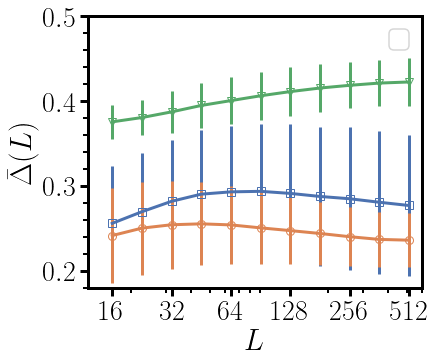

In [101]:
attack = 'Btw'
measures = ['meanS', 'Nsec']
X = np.sqrt(sizes)

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(12, 600)
ax.set_xticks([16, 32, 64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\bar{\Delta}(L)$')

for i, (Y, Y_err) in enumerate(zip(
    [all_mean_values[:,1], lower_mean_values[:,1], upper_mean_values[:,1]],
    [all_std_values[:,1], lower_std_values[:,1], upper_std_values[:,1]]
)):
    #Y_err = np.sqrt(all_std_values[:,1]/nseeds_values)
    ax.plot(X, Y, markers[i], markersize=8, fillstyle='none')
    ax.errorbar(X, Y, Y_err, color=f'C{i}', markersize=8)
ax.set_ylim(0.18, 0.5)
ax.legend()
plt.show()

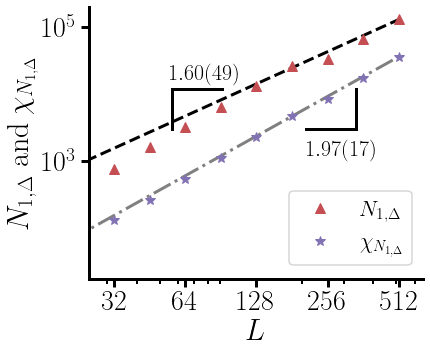

In [103]:
attack = 'Btw'
X = np.sqrt(sizes)

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

ax.set_xscale('log')
ax.set_xlabel(r'$L$')
ax.set_xlim(25, 650)
xticks = [32, 64, 128, 256, 512]
ax.set_xticks(xticks)
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_yscale('log')
ax.set_ylabel(r'$N_{1,{\Delta}}\mathrm{\; and\;} \chi_{N_{1,\Delta}}$')

Y = all_mean_values[:,2]
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, markers[3], color='C3', markersize=10, label=r'$N_{1,{\Delta}}$')
label1 = label=r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label1, zorder=-1
)

Y = all_std_values[:,2]#/ sizes
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, markers[4], color='C4', markersize=10, label=r'$\chi_{N_{1,\Delta}}$')

label2 = label=r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
ax.plot(
    X, powerlaw(X, slope, c), '-.', color='gray', 
    label=label2, zorder=-1
)
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

ax.plot([0.25, 0.4], [0.7, 0.7], '-', color='k', transform=ax.transAxes)
ax.plot([0.25, 0.25], [0.7, 0.55], '-', color='k', transform=ax.transAxes)
ax.text(0.24, 0.73, label1, transform=ax.transAxes, fontsize=22)

ax.plot([0.65, 0.8], [0.55, 0.55], '-', color='k', transform=ax.transAxes)
ax.plot([0.8, 0.8], [0.55, 0.7], '-', color='k', transform=ax.transAxes)
ax.text(0.65, 0.45, label2, transform=ax.transAxes, fontsize=22)

handles, labels = ax.get_legend_handles_labels()
## Markers
order = [0, 2]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.6, 0.05))

sns.despine()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_N1_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

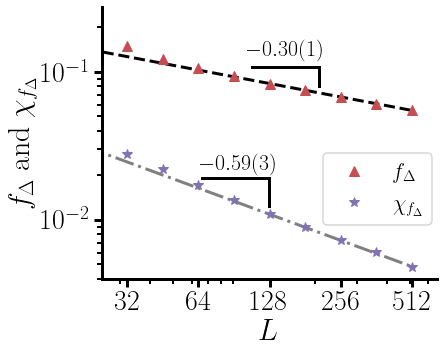

In [104]:
attack = 'Btw'
X = np.sqrt(sizes)

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

ax.set_xscale('log')
ax.set_xlabel(r'$L$')
ax.set_xlim(25, 650)
xticks = [32, 64, 128, 256, 512]
ax.set_xticks(xticks)
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_yscale('log')
#yticks = np.array(xticks)**2
#ax.set_yticks(yticks)
ax.set_ylabel(r'$f_{\Delta}\mathrm{\; and\;} \chi_{f_{\Delta}}$')
#ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
#ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

Y = all_mean_values[:,0]# / sizes
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, markers[3], color='C3', markersize=10, label=r'$f_{\Delta}$')
label1 = label=r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label1, zorder=-1
)

Y = all_std_values[:,0]#/ sizes
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, markers[4], color='C4', markersize=10, label=r'$\chi_{f_{\Delta}}$')

label2 = label=r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
ax.plot(
    X, powerlaw(X, slope, c), '-.', color='gray', 
    label=label2, zorder=-1
)
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

ax.plot([0.45, 0.65], [0.78, 0.78], '-', color='k', transform=ax.transAxes)
ax.plot([0.65, 0.65], [0.78, 0.71], '-', color='k', transform=ax.transAxes)
ax.text(0.43, 0.82, label1, transform=ax.transAxes, fontsize=22)

ax.plot([0.3, 0.5], [0.37, 0.37], '-', color='k', transform=ax.transAxes)
ax.plot([0.5, 0.5], [0.37, 0.27], '-', color='k', transform=ax.transAxes)
ax.text(0.29, 0.4, label2, transform=ax.transAxes, fontsize=22)

handles, labels = ax.get_legend_handles_labels()
## Markers
order = [0, 2]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.66, 0.2))

sns.despine()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_fDelta_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

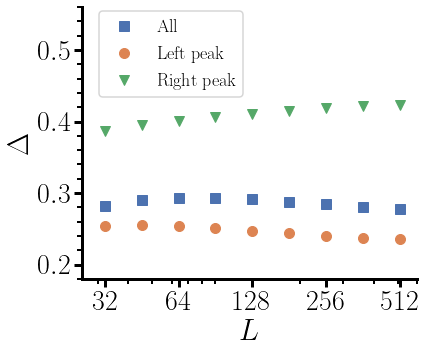

In [105]:
attack = 'Btw'
measures = ['meanS', 'Nsec']
X = np.sqrt(sizes)

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim(0.18, 0.56)
ax.set_xlim(26, 600)
ax.set_xticks([32, 64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\Delta$')

mean_values = {
    'all': all_mean_values[:,1],
    'lower': lower_mean_values[:,1],
    'upper': upper_mean_values[:,1]
}

std_values = {
    'all': all_std_values[:,1],
    'lower': lower_std_values[:,1],    
    'upper': upper_std_values[:,1]
}

labels = {
    'lower': r'$\Delta_{<\mathrm{th}}$',
    'all': r'$\Delta$',
    'upper': r'$\Delta_{>\mathrm{th}}$'
}

labels = {
    'lower': r'$<\mathrm{th}$',
    'all': r'$\mathrm{All}$',
    'upper': r'$>\mathrm{th}$'
}


labels = {
    'lower': r'$\mathrm{Left\;peak}$',
    'all': r'$\mathrm{All}$',
    'upper': r'$\mathrm{Right\;peak}$',
}

for i, (kind, Y) in enumerate(mean_values.items()):
    #Y_err = np.sqrt(all_std_values[:,1]/nseeds_values)
    ax.plot(
        X, Y, markers[i], markersize=10,# fillstyle='none'
        label=labels[kind]
    )
    #ax.errorbar(X, Y, Y_err, color=f'C{i}', markersize=8)
ax.legend(loc=(0.05, 0.67), fontsize=18)
sns.despine()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_Delta_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

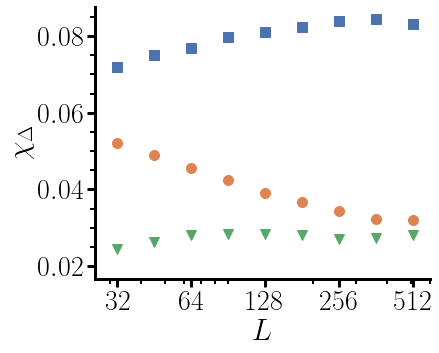

In [106]:
attack = 'Btw'
measures = ['meanS', 'Nsec']
X = np.sqrt(sizes)

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(26, 600)
ax.set_xticks([32, 64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\chi_{\Delta}$')

for i, (kind, Y) in enumerate(std_values.items()):
    #Y_err = np.sqrt(all_std_values[:,1]/nseeds_values)
    ax.plot(
        X, Y, markers[i], markersize=10, #fillstyle='none'
        label=labels[kind]
    )
    #ax.errorbar(X, Y, Y_err, color=f'C{i}', markersize=8)
    if i == 1:
        Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
        c = Y[-1] / X[-1]**slope
        label2 = label=r'${{{:.2f}}}({{{:.0f}}})$'.format(-slope, 100*y_err)
        #ax.plot(
        #    X, powerlaw(X, slope, c), '-.', color='gray', 
        #    label=label2, zorder=-1
        #)

#ax.set_ylim(0.18, 0.5)
sns.despine()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_chiDelta_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

NameError: name '_datas' is not defined

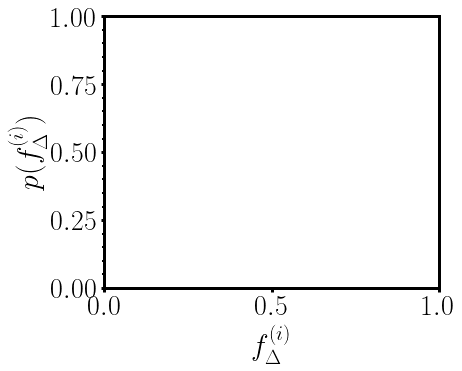

In [107]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
ax.set_ylabel(r'$p(f_{\Delta}^{(i)})$')
ax.set_xlabel(r'$f_{\Delta}^{(i)}$')

for N, data in _datas.items():
    _data = data[:,0]
    freq, bin_edges = np.histogram(_data, bins=50, density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    label = r'${{{}}}$'.format(N)
    ax.plot(bin_centers, freq, label=label)
    ax.legend(fontsize=18)
sns.despine()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_proba_fDelta_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

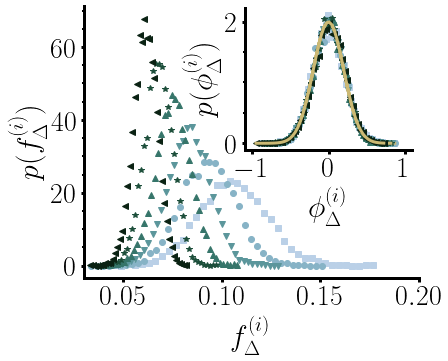

In [108]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
ax.set_xlim(0.03, 0.2)
ax.set_xticks([0.05, 0.1, 0.15, 0.2])
ax.set_ylabel(r'$p(f_{\Delta}^{(i)})$')
ax.set_xlabel(r'$f_{\Delta}^{(i)}$')

_datas = {N: datas[N] for N in datas.keys() if N > 3000 and N < 140000}

colormap = sns.cubehelix_palette(
    len(_datas), start=2, rot=0.3, light=0.8, dark=0.1
)

for i, (N, data) in enumerate(_datas.items()):
    _data = data[:,0]
    freq, bin_edges = np.histogram(_data, bins=40, density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    label = r'${{{}}}$'.format(N)
    ax.plot(
        bin_centers, freq, 
        markers[i], 
        color=colormap[i], 
        #label=label
    )
    
bbox_to_anchor = (.52, .52, .5, .52)
axins = inset_axes(
    ax, width="100%", height="100%",
    bbox_to_anchor=bbox_to_anchor,
    bbox_transform=ax.transAxes
)
axins.set_ylabel(r'$p(\phi_{\Delta}^{(i)})$')
axins.set_xlabel(r'$\phi_{\Delta}^{(i)}$')
axins.set_xlim(-1.1, 1.1)

def gaussian(X, mu, sigma, c=1):
    return (c/np.sqrt(2*np.pi)*sigma)*np.exp(-0.5*((X-mu)/sigma)**2)

for i, (N, data) in enumerate(_datas.items()):
    L = np.sqrt(N)
    _data = (data[:,0]-data[:,0].mean())*L**(0.6)
    freq, bin_edges = np.histogram(_data, bins=50, density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    X = bin_centers
    Y = freq
    axins.plot(X, Y, markers[i], color=colormap[i])
    mu, sigma, c = 0, 0.2, 25
    axins.plot(X, gaussian(X, mu, sigma, c), linestyle='-', color='C8')

sns.despine()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_proba_fDelta_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()



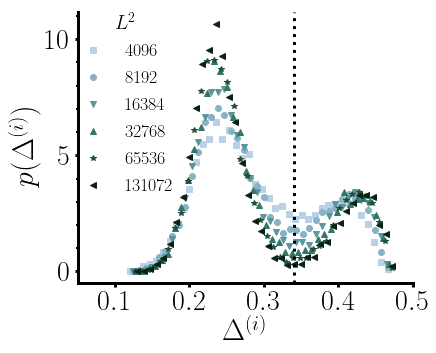

In [109]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_xlim(0.05, 0.5)
ax.set_ylabel(r'$p(\Delta^{(i)})$')
ax.set_xlabel(r'$\Delta^{(i)}$')

colormap = sns.cubehelix_palette(
    len(_datas), start=2, rot=0.3, light=0.8, dark=0.1
)

for i, (N, data) in enumerate(_datas.items()):
    _data = data[:,1] 
    freq, bin_edges = np.histogram(_data, bins=40, density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    label = r'${{{}}}$'.format(N) 
    ax.plot(bin_centers, freq, markers[i], color=colormap[i], label=label)

ax.axvline(0.34, color='k', linestyle=':')
legend = ax.legend(loc=(-0.03, 0.3), fontsize=18, frameon=False)
legend.set_title(r'$L^2$', prop={'size':20})
sns.despine()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_proba_Delta_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

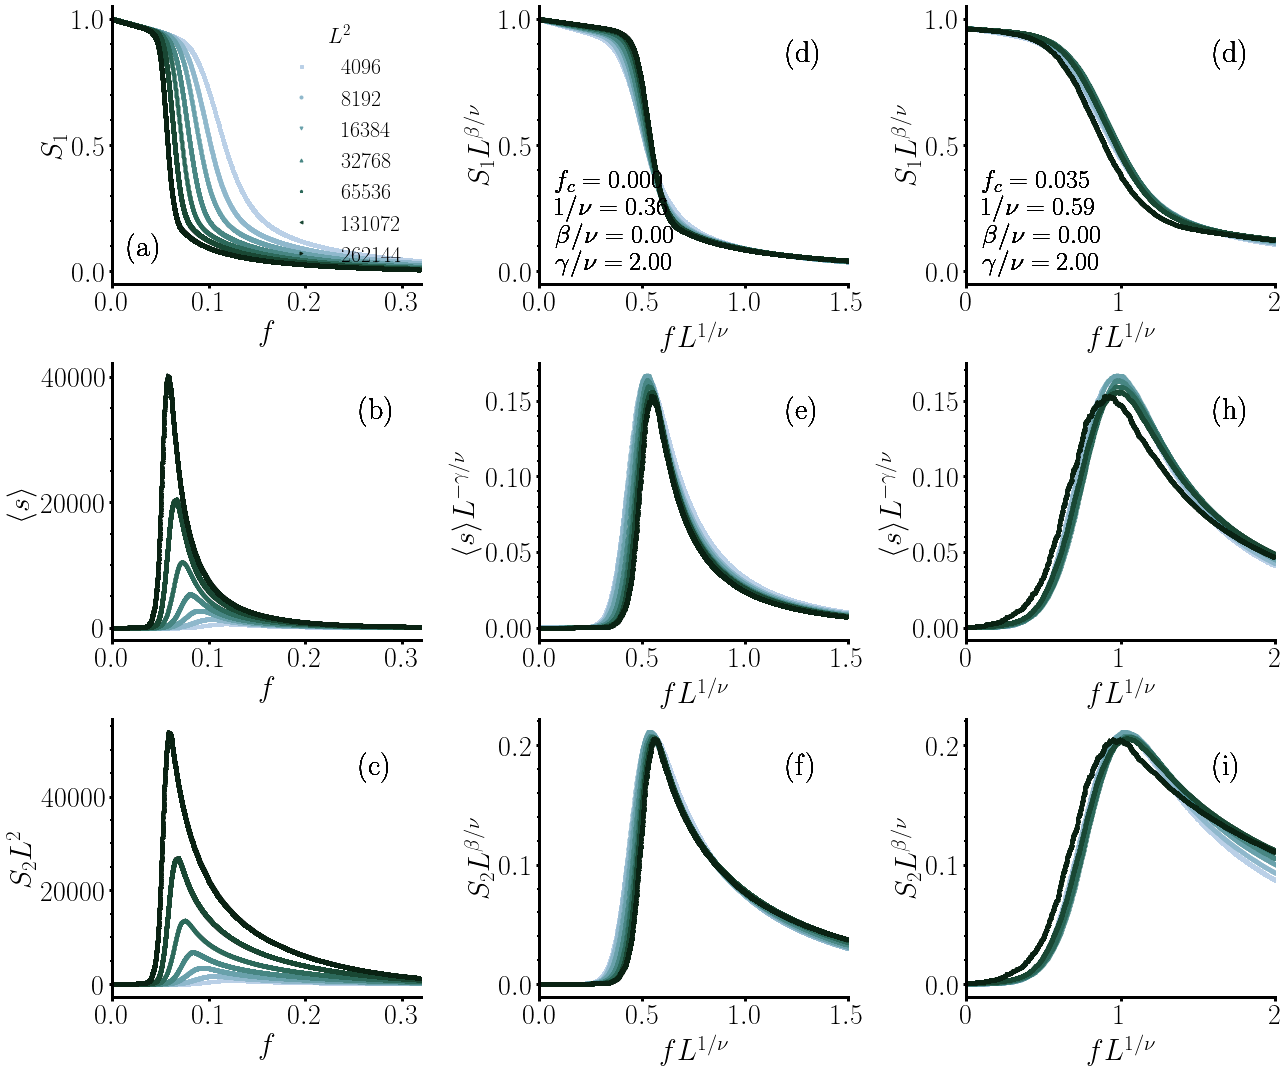

In [56]:
attack = 'Btw'
sizes = [4096, 8192, 16384, 32768, 65536, 131072, 262144]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 3
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
for ax in axes[:,0]:
    ax.set_xlim(0, 0.32)
    ax.set_xticks([0.0, 0.1, 0.2, 0.3])
    ax.set_xlabel(r'$f$')
for ax in axes[:,1]:
    ax.set_xlim(0, 1.5)
    ax.set_xlabel(r'$f L^{1/\nu}$')
for ax in axes[:,2]:
    ax.set_xlim(0, 2)
    ax.set_xlabel(r'$f L^{1/\nu}$')
    
ax = axes[0,0]
ax.set_ylabel(r'$S_1$')
ax = axes[1,0]
ax.set_ylabel(r'$\langle s\rangle$')
ax = axes[2,0]
ax.set_ylabel(r'$S_2L^2$')

for i in [1, 2]:
    ax = axes[0,i]
    ax.set_ylabel(r'$S_1 L^{\beta/\nu}$')
    ax = axes[1,i]
    ax.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$')
    ax = axes[2,i]
    ax.set_ylabel(r'$S_2 L^{\beta/\nu}$')
        
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    ax.text(0.05, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = axes[1,0]
    ax.text(0.8, 0.8, letters[1], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.meanS, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    ax = axes[2,0]
    ax.text(0.8, 0.8, letters[2], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.Nsec, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    
for j in [1, 2]:
    if j == 1:
        one_over_nu = 0.36
        gamma_over_nu = 2
        beta_over_nu = 0
        fc = 0.0
    else:
        one_over_nu = 0.59
        gamma_over_nu = 2
        beta_over_nu = 0
        fc = 0.035
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        L = np.sqrt(N)

        ax = axes[0,j]
        ax.text(0.8, 0.8, letters[3], transform=ax.transAxes, fontsize=30)

        ax.plot((df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
        ax.text(
            0.05, 0.35, r'$f_c = {{{:.3f}}}$'.format(fc), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.25, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.15, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.05, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), 
            transform=ax.transAxes, fontsize=26
        )

        ax = axes[1,j]
        ax.text(0.8, 0.8, letters[1+3*j], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )  

        ax = axes[2,j]
        ax.text(0.8, 0.8, letters[2+3*j], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.Nsec*L**(beta_over_nu-2), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )

legend = axes[0,0].legend(loc='upper right', fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

### Comp size distribution

In [2]:
def get_histo(comp_sizes, nbins=None, log=True, density=True):
    
    if nbins is None:
        nbins = 20
    
    mask = comp_sizes > 0
    comp_sizes = comp_sizes[mask]     
    min_s = np.min(comp_sizes)
    max_s = np.max(comp_sizes)
    if log:
        bins = np.logspace(np.log10(min_s), np.log10(max_s), nbins)
    else:
        bins = np.linspace(min_s, max_s+1, nbins)
    freq, bin_edges = np.histogram(comp_sizes, bins=bins, density=density)
    freq_norm = freq.astype('float')
    freq_norm[freq_norm==0] = np.NaN
    
    freq_norm = freq_norm / np.diff(bin_edges)
    
    mask = ~np.isnan(freq_norm)
    X = bins[:-1]
    X = X[mask]
    Y = freq_norm[mask]

    return X, Y

attack = 'Btw'
sizes = [8192, 16384, 32768, 65536, 131072, 262144]
#sizes = [65536]
dropLargest = 0

f_values_dict = {
    262144: ['0.05481', '-', '-'],
    131072: ['0.06100', '0.06737', '0.06874'],
    65536: ['0.06786', '0.07231', '0.07579'],
    32768: ['0.07524', '0.08041', '0.08307'],
    16384: ['0.08338', '0.09088', '0.09326'],
    8192: ['0.09316', '0.10266', '0.10789']
}

all_comp_sizes = {}
nseeds_values = {}

for size in sizes:
    print(size)
    f_value = f_values_dict[size][0]
    comp_sizes, nseeds = load_comp_sizes_data(net_type, param, size, attack, f_value, dropLargest)
    nseeds_values[size] = nseeds
    all_comp_sizes[size] = comp_sizes

print(nseeds_values)

8192
16384
32768
65536
131072
262144


{8192: 10000, 16384: 1000, 32768: 1000, 65536: 10000, 131072: 9958, 262144: 1}


In [3]:
nseeds_values[262144] = 650

0.93214


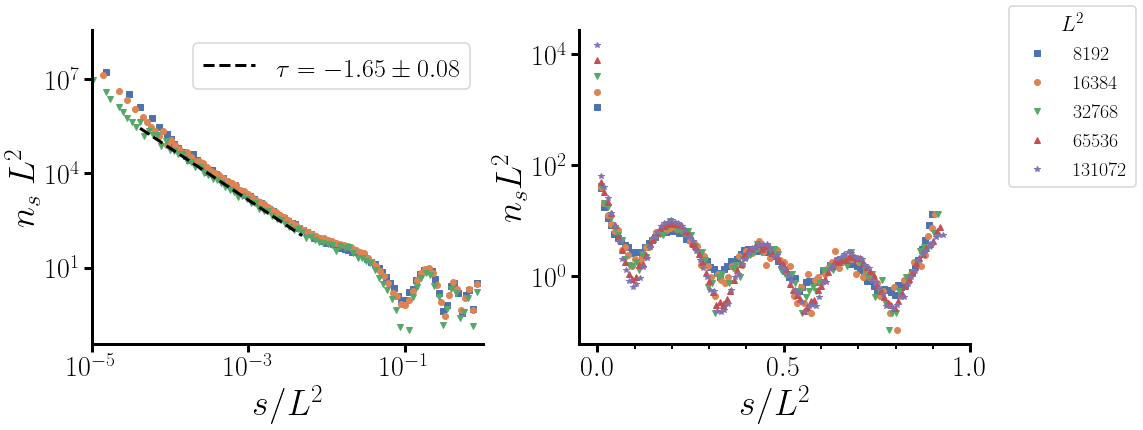

In [11]:
ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols,6), ncols=ncols)

for ax in axes:
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    
ax = axes[0]
ax.set_xlim(1e-5, 1)
#ax.set_ylim(0.5, 1e6)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s\;L^2$', fontsize=36)    

for i, N in enumerate(sizes[3:]):

    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 100   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=True, density=False)
    
    X = X / N
    Y = Y * N / nseeds_values[N]
    #Y = Y*N**2
    
    ax.plot(
        X, Y, marker=markers[i], linestyle=''
    )
    if N == sizes[-1]:
        _X = X[10:-40]
        _Y = Y[10:-40]
        Y_pred, slope, y_err = getLinearReg(_X, _Y)
        label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        ax.plot(_X, Y_pred, '--', color='k', label=label)

ax.legend()      

ax = axes[1]
#ax.set_xscale('log')
ax.set_xlim(-0.05, 1)
#ax.set_ylim(1e3, 1e6)
ax.set_yscale('log')
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s L^2$', fontsize=36)    

for i, N in enumerate(sizes[:-1]):

    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 100   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=False, density=False)
    
    X = X / N
    Y = Y * N / nseeds_values[N]
    
    ax.plot(
        X, Y, marker=markers[i], linestyle='', label=r'${{{}}}$'.format(N)
    ) 
legend = ax.legend(loc=(01.1, 0.5), fontsize=20)
legend.set_title(r'$L^2$', prop={'size':22})

c = 0.20
c_max = 1-float(f_values_dict[65536][0])
print(c_max)
N = 32768
for ax in axes:
    #ax.axvline(c, color='k', linestyle=':')
    #ax.axvline(0.44, color='k', linestyle=':')
    #ax.axvline(0.68, color='k', linestyle=':')
    #ax.axvline(c_max-0.27, color='k', linestyle=':')
    #ax.axvline(c_max, color='k', linestyle=':')
    #ax.axvline(4*c, color='k', linestyle=':')
    #for i in range(10):
    #    ax.axvline((1-rc_values[N][i])*delta_values[N][i], color='k', linestyle=':')
        #ax.axvline((rc_values[N][i])*delta_values[N][i], color='k', linestyle=':')
        #ax.axvline((1-rc_values[N][i])-delta_values[N][i], color='k', linestyle=':')
    pass
    
plt.tight_layout() 
sns.despine()
plt.show()

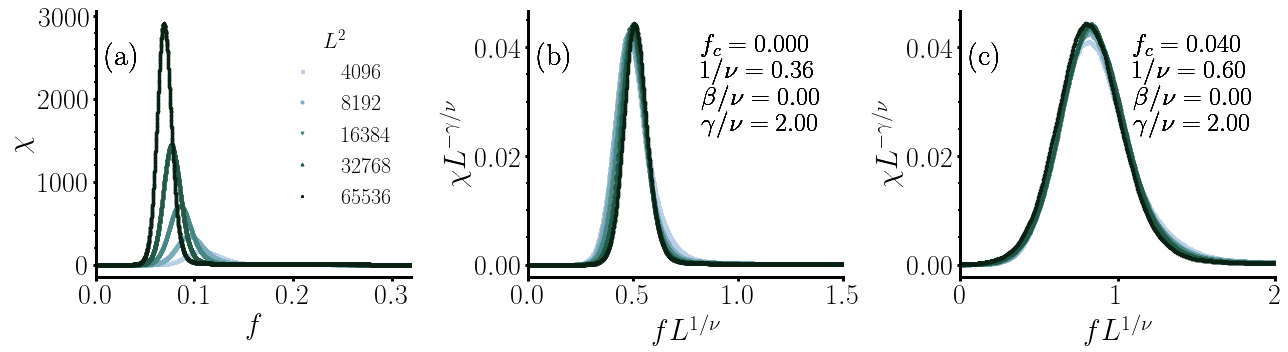

In [23]:
attack = 'Btw'
sizes = [4096, 8192, 16384, 32768, 65536]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
ax = axes[0]
ax.set_xlim(0, 0.32)
ax.set_xticks([0.0, 0.1, 0.2, 0.3])
ax.set_xlabel(r'$f$')
ax = axes[1]
ax.set_xlim(0, 1.5)
ax.set_xlabel(r'$f L^{1/\nu}$')
ax = axes[2]
ax.set_xlim(0, 2)
ax.set_xlabel(r'$f L^{1/\nu}$')
    
ax = axes[0]
ax.set_ylabel(r'$\chi$')

for i in [1, 2]:
    ax = axes[i]
    ax.set_ylabel(r'$\chi L^{-\gamma/\nu}$')

        
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0]
    ax.text(0.03, 0.8, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.varSgcc, linestyle='', marker=markers[i], markersize=3, color=colormap[i],
        label=r'${{{}}}$'.format(N)
    )
    
for j in [1, 2]:
    if j == 1:
        one_over_nu = 0.36
        gamma_over_nu = 2
        beta_over_nu = 0
        fc = 0.0
    else:
        one_over_nu = 0.6
        gamma_over_nu = 2
        beta_over_nu = 0
        fc = 0.04
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        L = np.sqrt(N)
        ax = axes[j]
        ax.text(
            0.55, 0.85, r'$f_c = {{{:.3f}}}$'.format(fc), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.55, 0.75, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.55, 0.65, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.55, 0.55, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        
        ax.text(0.03, 0.8, letters[j], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.varSgcc*L**(-gamma_over_nu), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )  

legend = axes[0].legend(loc='upper right', fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_chi_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

### $\mathrm{IB}q$ attacks

In [3]:
sizes = [
    #128, 256, 512, 
    #1024, 2048, 
    #4096, 
    8192, 
    #16384, 32768, 65536, 131072
]
l_values = np.arange(2, 200)
nseeds = 10000
rc_values, rc_values_std = get_rc_values(
    sizes, l_values=l_values, 
    #min_nseeds=100, 
    nseeds=nseeds,
    base_attack='Btw'
)
l_cutoff = get_l_cutoff(
    sizes, threshold=1e-2, rc_values=rc_values,
    base_attack='Btw'
)
print(l_cutoff)

INFO: 06/19/2021 10:45:27 AM 8192


{8192: 42}


In [52]:
l_cutoff[65536] = 110
l_cutoff[131072] = np.nan

In [5]:
attacks = [
    'Btw',
    'Ran', 
    'Deg', 
    'Btw_cutoff2', 
    #'Btw_cutoff3', 
    'Btw_cutoff4', 
    #'Btw_cutoff5', 'Btw_cutoff6', 'Btw_cutoff7', 
    'Btw_cutoff8', 'Btw_cutoff16', 
    'Btw_cutoff32',
    #'Btw_cutoff40', 
    'Btw_cutoff50', 
    #'Btw_cutoff60'#, 'Btw_cutoff70'
    'Btw_cutoff80',
    'Btw_cutoff110'
]

sizes = [
    #4096, 8192, 
    #16384, 
    #32768, 
    65536, 
    #131072, 262144
]

data = {}
for k, attack in enumerate(attacks):
    #print(attack)
    data[attack] = {}
    
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
        except FileNotFoundError:
            continue
    N_values = np.array(list(dfs.keys()))
    L_values = np.sqrt(N_values)
    #print(f'{attack}\tnum\t', [(N, np.round(df.num.idxmax()/N, 5)) for N, df in dfs.items()])
    #print(f'{attack}\tmeanS\t', [(N, np.round(df.meanS.idxmax()/N, 5)) for N, df in dfs.items()])
    print(f'{attack}\tNsec\t', [(N, np.round(df.Nsec.idxmax()/N, 5)) for N, df in dfs.items()])

Btw	Nsec	 [(65536, 0.07512)]
Ran	Nsec	 [(65536, 0.50591)]
Deg	Nsec	 [(65536, 0.30292)]
Btw_cutoff2	Nsec	 [(65536, 0.29756)]
Btw_cutoff4	Nsec	 [(65536, 0.2643)]
Btw_cutoff8	Nsec	 [(65536, 0.22693)]
Btw_cutoff16	Nsec	 [(65536, 0.20096)]
Btw_cutoff32	Nsec	 []
Btw_cutoff50	Nsec	 [(65536, 0.15413)]
Btw_cutoff80	Nsec	 [(65536, 0.10609)]
Btw_cutoff110	Nsec	 [(65536, 0.07664)]


In [5]:
measures = ['num']
attacks = [
    'Ran', 
    'Deg', 
    'Btw_cutoff2', 
    'Btw_cutoff3', 
    'Btw_cutoff4', 
    #'Btw_cutoff5', 'Btw_cutoff6', 'Btw_cutoff7', 
    'Btw_cutoff8', 
    'Btw_cutoff16'
]
sizes = [4096, 8192, 16384, 32768, 65536, 131072, 262144]
min_nseeds = 10000
data = {}
for attack in attacks:
    for N in sizes:
        try:
            df = load_dataframe(net_type, N, param, attack, min_nseeds=min_nseeds)
        except FileNotFoundError:
            print('not found', attack, N, sep='\t')
            continue
            
        try:
            df.num
        except:
            print('old file', attack, N, sep='\t')

old file	Btw_cutoff3	4096
old file	Btw_cutoff3	8192
old file	Btw_cutoff3	16384
not found	Btw_cutoff4	262144
old file	Btw_cutoff16	4096
not found	Btw_cutoff16	8192
old file	Btw_cutoff16	32768
old file	Btw_cutoff16	65536


In [9]:
sizes = [4096, 8192, 16384, 32768, 65536, 131072, 262144]

from robustness.auxiliary import read_data_file
net_type = 'DT'
param = 'param'
seed = 9999

dir_name = NETWORKS_DIR / net_type
for attack in attacks:
    print(attack)
    for size in sizes:
        base_net_name, base_net_name_size = get_base_network_name(
            net_type, size, param
        )
        base_net_dir = dir_name / base_net_name / base_net_name_size
        network = f'{base_net_name_size}_{seed:05d}'
        attack_dir_name = base_net_dir / network / attack
        comp_data_file = 'comp_data'
        try:
            aux = read_data_file(
                str(attack_dir_name), comp_data_file, 
                reader='pandas', sep=' ', header=None
            ).values
        except FileNotFoundError:
            print(f'{size}\tnot found')
            continue
        if aux.shape[1] != 6:
            print(size, aux.shape[1], sep='\t')

Ran
Deg
262144	not found
Btw_cutoff2
Btw_cutoff3
Btw_cutoff4
262144	not found
Btw_cutoff8
Btw_cutoff16
65536	3


In [8]:
from robustness.auxiliary import read_data_file
net_type = 'DT'
param = 'param'
seed = 999

dir_name = NETWORKS_DIR / net_type
for attack in attacks:
    print(attack)
    for size in sizes:
        base_net_name, base_net_name_size = get_base_network_name(
            net_type, size, param
        )
        base_net_dir = dir_name / base_net_name / base_net_name_size
        network = f'{base_net_name_size}_{seed:05d}'
        attack_dir_name = base_net_dir / network / attack
        comp_data_file = 'comp_data'
        try:
            aux = read_data_file(
                str(attack_dir_name), comp_data_file, 
                reader='pandas', sep=' ', header=None
            ).values
        except FileNotFoundError:
            print(f'{size}\tnot found')
            raise
        if aux.shape[1] != 6:
            print(size, aux.shape[1], sep='\t')

Ran
Deg
Btw_cutoff2
Btw_cutoff3
Btw_cutoff4
Btw_cutoff8
Btw_cutoff16
65536	3


In [2]:
measures = ['num', 'Nsec']
attacks = [
    'Ran', 
    'Deg', 
    'Btw_cutoff2', 
    #'Btw_cutoff3', 
    'Btw_cutoff4', 
    #'Btw_cutoff5', 'Btw_cutoff6', 'Btw_cutoff7', 
    'Btw_cutoff8', 
    'Btw_cutoff16'
]

sizes = [4096, 8192, 16384, 32768, 65536, 131072, 262144]

print('attack\t          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max')

data = {}
for k, attack in enumerate(attacks):
    #print(attack)
    data[attack] = {}
    
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=10000)
        except FileNotFoundError:
            print(attack, N)
            continue
    N_values = np.array(list(dfs.keys()))
    L_values = np.sqrt(N_values)
    for i, measure in enumerate(measures):

        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
        c = measure_values[-3] / L_values[-3]**slope
        
        if measure in ['Sgcc', 'Nsec']:
            beta_over_nu = 2 - slope
            delta_beta = y_err
        elif measure in ['meanS', 'varSgcc', 'num']:
            gamma_over_nu = slope
            delta_gamma = y_err               
        data[attack][measure] = [L_values, measure_values, Y_pred, slope, y_err, c]
            
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_nu/(beta_over_nu+gamma_over_nu)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    
    nu = 4/3
    if True:
        print(
            '{:10}\t{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:10.4f}{:10.0f}'.format(
                attack, beta_over_nu, beta_over_nu*nu, gamma_over_nu, gamma_over_nu*nu,
                2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau, np.max(N_values)
            )
        )

attack	          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max


INFO: 06/25/2021 12:20:01 PM NumExpr defaulting to 4 threads.


KeyboardInterrupt: 

In [69]:
print('beta = ', round(5/36,3))
print('gamma = ', round(43/18,3))

beta =  0.139
gamma =  2.389


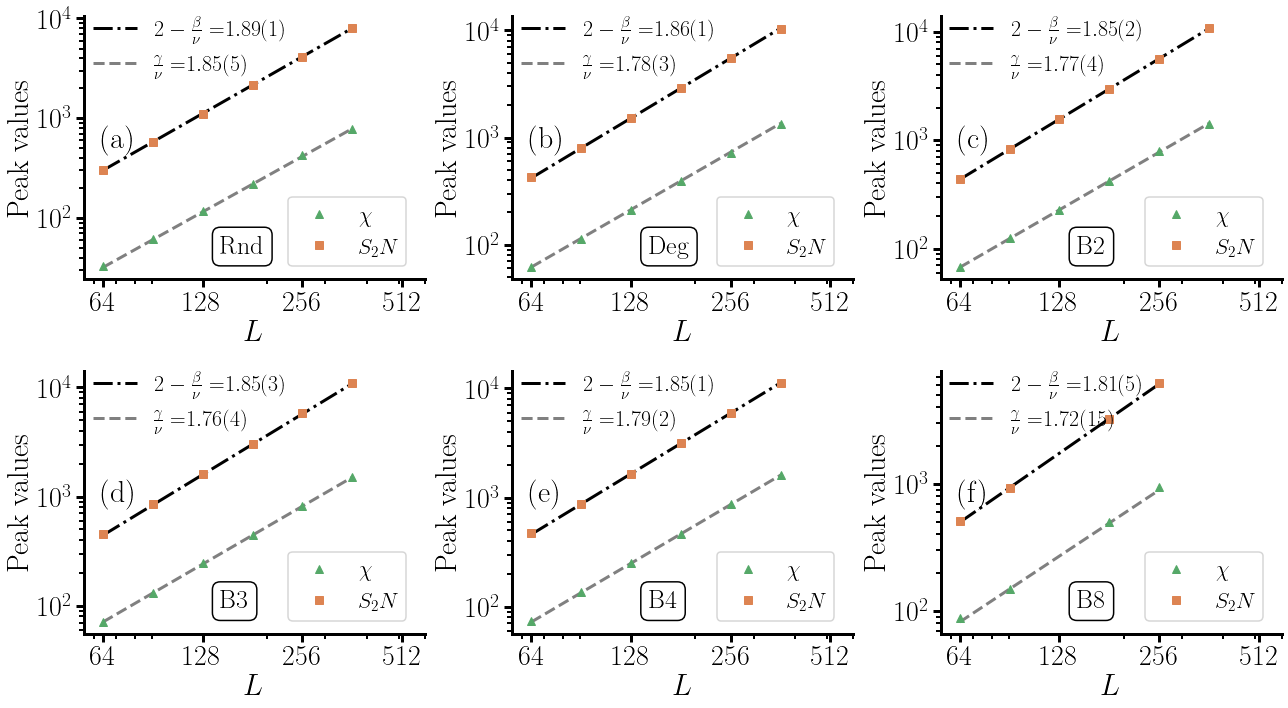

In [53]:
measures = ['meanS', 'num_over_denom']

ncols = 3
nrows = len(attacks) // ncols + bool(len(attacks) % ncols)
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(56, 600)
    ax.set_xticks([64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
for k, attack in enumerate(attacks):
    ax = axes[k]

    ax.text(0.05, 0.5, letters[k], transform=ax.transAxes, fontsize=30)
    bbox = {'boxstyle': 'round', 'fc': 'None'}
    ax.text(0.4, 0.1, attack_dict[attack], transform=ax.transAxes, fontsize=26, bbox=bbox)
    ax.set_ylabel(r'$\mathrm{Peak\;values}$')

    for i, measure in enumerate(measures):

        L_values, measure_values, Y_pred, slope, y_err, c = data[attack][measure]    

        if measure == 'meanS':
            label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
            label1 = label
            line1, = ax.plot(L_values, powerlaw(L_values, slope, c), '--', color='grey', label=label)
            
        if measure == 'num':
            label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
            label1 = label
            line1, = ax.plot(L_values, powerlaw(L_values, slope, c), '--', color='grey', label=label)

        if measure == 'varSgcc':
            label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
            label1 = label
            line1, = ax.plot(L_values, powerlaw(L_values, slope, c), '--', color='grey', label=label)

        elif measure == 'Nsec':
            label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
            label2 = label
            line2, = ax.plot(L_values, powerlaw(L_values, slope, c), '-.', color='k', label=label)   
            
        elif measure == 'Sgcc':
            label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
            label2 = label
            line2, = ax.plot(L_values, powerlaw(L_values, slope, c), ':', color='C8', label=label)   

        markers1, = ax.plot(
            L_values, measure_values, marker_dict[measure], 
            color=color_dict[measure], markersize=8, 
            label=measures_dict[measure]
        )

    handles, labels = ax.get_legend_handles_labels()
    ## Markers
    order = [1, 3, 5][:len(measures)]
    legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
              fontsize=22, loc=(0.6, 0.05))

    ax.add_artist(legend1)
    ## Lines
    order = [2, 0, 4][:len(measures)]
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
              fontsize=22, loc=(0.0, 0.73), frameon=False)


sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'beta_gamma_nu_scaling_Bl_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [65]:
Params = namedtuple('Param', ['fmin', 'fmax', 'ymin', 'ymax'])

attack_params = {
    'Ran': Params(0.495, 0.505, 3, 7),
    'Deg': Params(0.298, 0.308, 2, 6),
    'DegU': Params(0.37, 0.385, 2, 8),
    'Btw_cutoff2': Params(0.293, 0.305, 2, 7),
    'Btw_cutoff3': Params(0.27, 0.29, 1, 8),
    'Btw_cutoff4': Params(0.255, 0.275, 1, 8),
    'Btw_cutoff5': Params(0.23, 0.28, 1, 8),
    'Btw_cutoff6': Params(0.22, 0.26, 1, 8),
    'Btw_cutoff7': Params(0.22, 0.26, 1, 8),
    'Btw_cutoff8': Params(0.215, 0.235, 1, 8),
    'Btw_cutoff9': Params(0.20, 0.24, 1, 8),
    'Btw_cutoff10': Params(0.18, 0.24, 1, 8),
    'Btw_cutoff11': Params(0.17, 0.24, 1, 8),
    'Btw_cutoff16': Params(0.19, 0.21, 1, 8),
}
for l in range(12, 16):
    attack_params[f'Btw_cutoff{l}'] = Params(0.17, 0.24, 1, 8)

[ 32768  65536 131072]
Ran                 0.49986 +- 0.00034  0.000673
[ 32768  65536 131072]
Deg                 0.30324 +- 0.00002  0.000078
[ 32768  65536 131072]
Btw_cutoff2         0.29882 +- 0.00024  0.000806
[ 32768  65536 131072]
Btw_cutoff3         0.27868 +- 0.00007  0.000246
[ 32768  65536 131072]
Btw_cutoff4         0.26554 +- 0.00039  0.001456
[32768 65536]
Btw_cutoff8         0.22373 +- 0.00000  0.000000
[32768 65536]
Btw_cutoff16        0.19880 +- 0.00000  0.000000


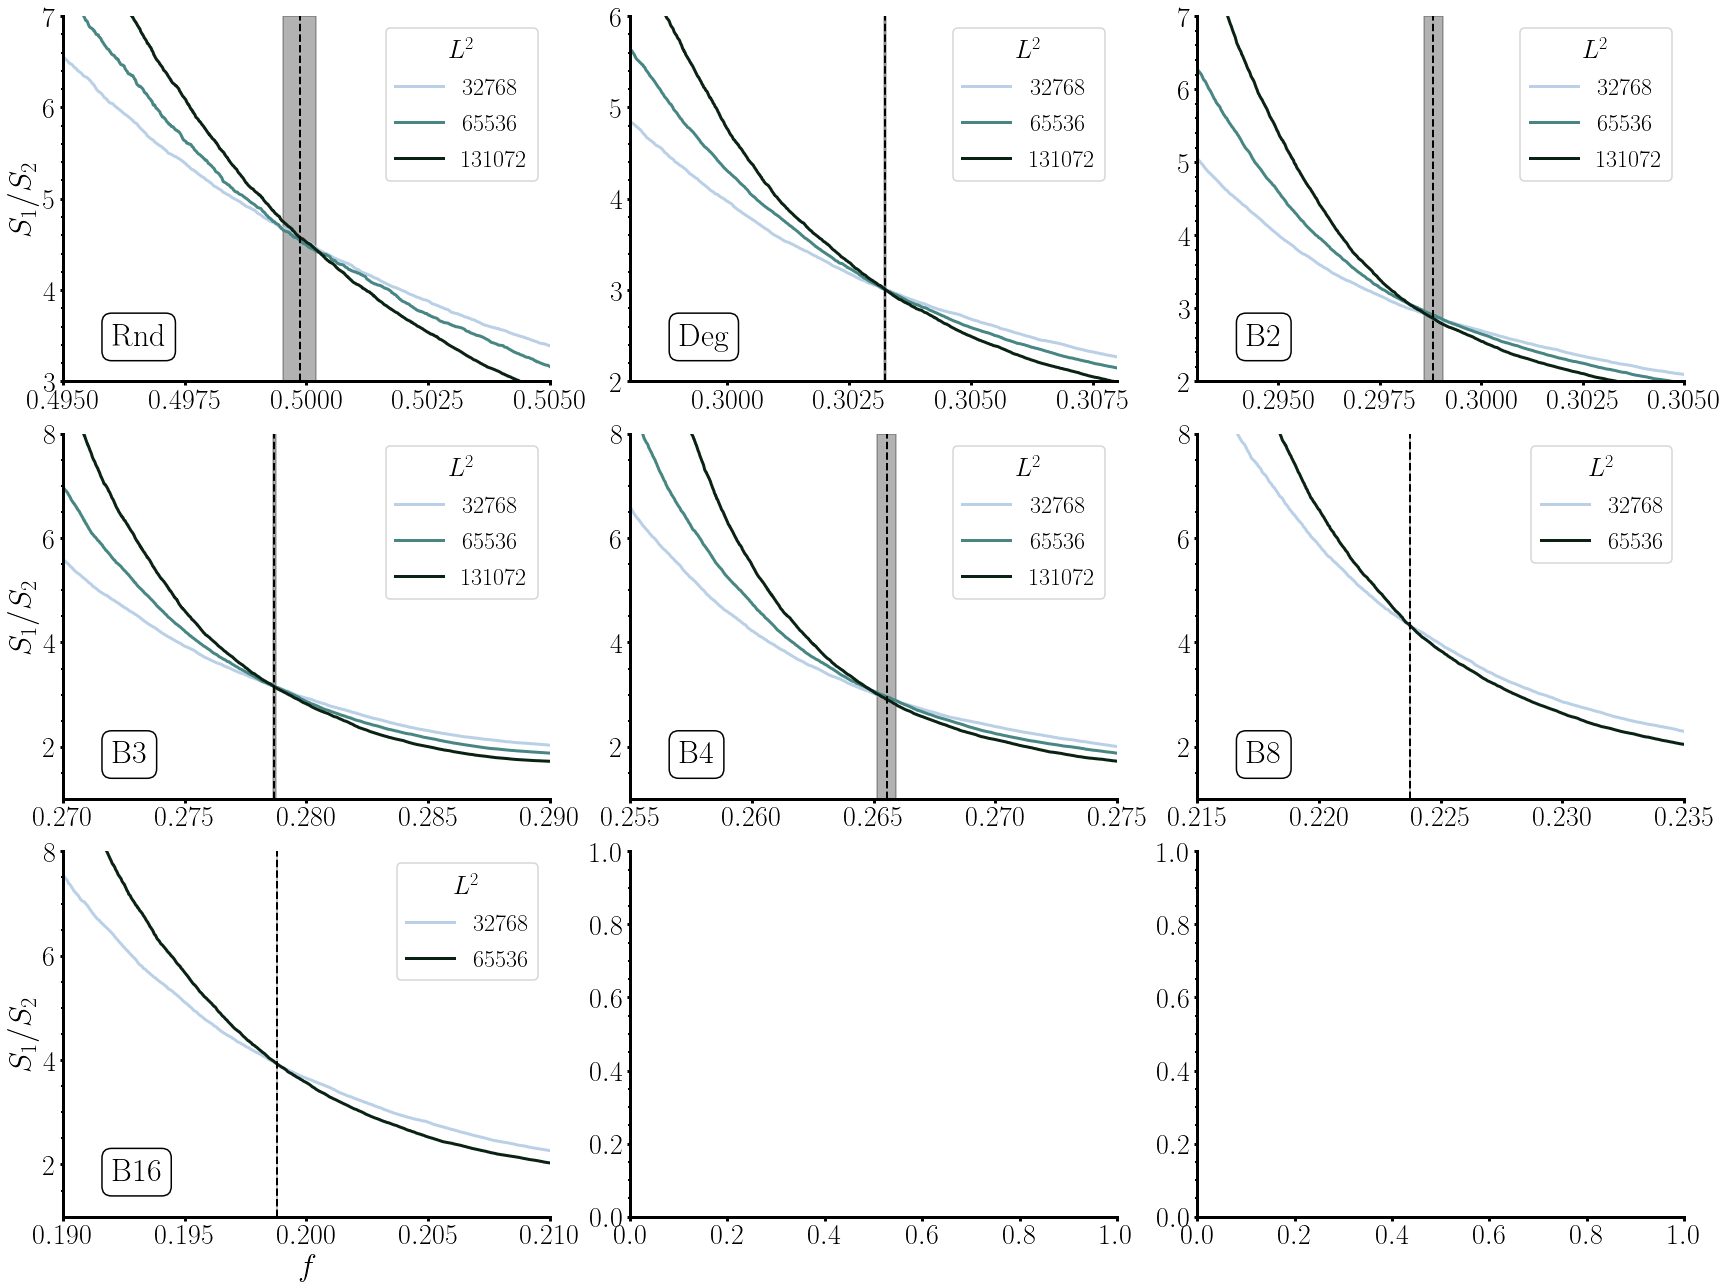

In [69]:
def plot_S1_over_S2(net_type, attacks):
    
    ncols = 3
    nrows = len(attacks) // ncols 
    if len(attacks) % ncols:
        nrows += 1
    fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    fc_values = {}
    for j, attack in enumerate(attacks):

        sizes = [
            #1024, 2048, 4096, 
            #8192, 
            #16384, 
            32768, 65536,
            131072, 262144
        ]  
        
        dfs = {}
        for N in sizes:
            try:
                dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=10000)
            except FileNotFoundError:
                continue

        N_values = np.sort(list(dfs.keys()))[-4:]
        L_values = np.sqrt(N_values)
        print(N_values)
        dfs = {N: dfs[N] for N in N_values}
        
        ax = axes[j]
        fmin, fmax, ymin, ymax = attack_params[attack]
        ax.set_xlim(fmin, fmax)
        ax.set_ylim(ymin, ymax)
        if (j % ncols) == 0:
            ax.set_ylabel(r'$S_1/S_2$', fontsize=32)
        if j >= ncols*(nrows-1):
            ax.set_xlabel(r'$f$', fontsize=32)

        colors = sns.cubehelix_palette(
            len(N_values), start=2, rot=0.3, 
            light=0.8, dark=0.1
        )
        for i, N in enumerate(N_values):
            df = dfs[N]
            S1_over_S2 = N * df.Sgcc / df.Nsec
            ax.plot(df.f, S1_over_S2, '-', label=r'${{{}}}$'.format(N), color=colors[i])
        
        if not dfs: ## Dict is empty
            continue

        mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=False, verbose=False, method='beta')
        
        fc_values[attack] = (mean_fc, std_fc)
        
        print('{:20}{:.5f} +- {:.5f}{:10f}'.format(attack, mean_fc, std_fc, std_fc/mean_fc))
        
        ax.axvline(mean_fc, linestyle='--', color='k', linewidth=2)
        ax.fill_betweenx([ymin, ymax], mean_fc-std_fc, mean_fc+std_fc, color='k', alpha=0.3)
    
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.1, 0.1, attack_dict[attack], fontsize=32, transform=ax.transAxes, bbox=bbox, 
                horizontalalignment='left')
        #ax.text(0.04, 0.12, letters[j], fontsize=36, transform=ax.transAxes, 
        #        horizontalalignment='left')
        legend = ax.legend(loc='best', fontsize=24)
        legend.set_title(r'$L^2$', prop={'size':26})

    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'crossing_method_B_' + net_type)
    plt.savefig(fig_name + '.png', transparent=False)
    plt.savefig(fig_name + '.pdf')
    
    plt.show()
    
    return fc_values
    
net_type = 'DT'
attacks = ['Ran', 'Deg'] + ['Btw_cutoff%d' % l for l in range(2, 17)]
attacks = ['Ran', 'Deg'] + ['Btw_cutoff%d' % l for l in [2, 3, 4, 8, 16]]
fc_values = plot_S1_over_S2(net_type, attacks)

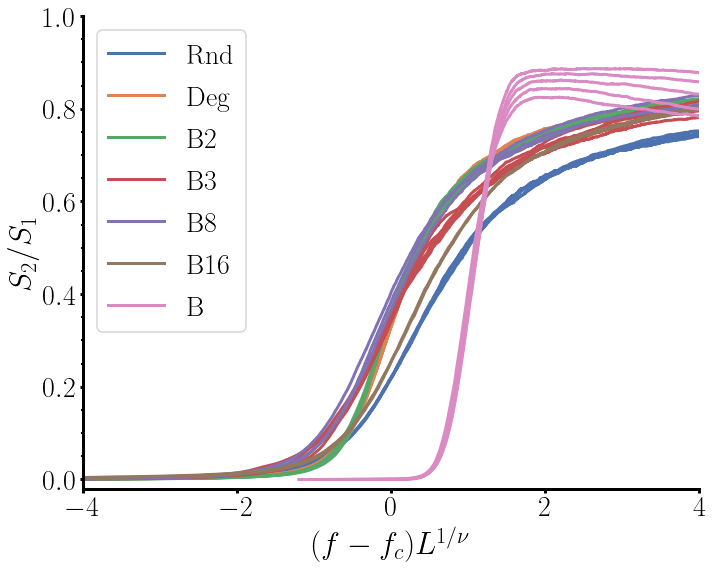

In [68]:
def load_dataframes(net_type, sizes, param, attack, min_nseeds=None, nseeds=None):
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(
                net_type, N, param, attack, min_nseeds=min_nseeds, nseeds=nseeds
            )
        except FileNotFoundError:
            continue
    N_values = np.sort(list(dfs.keys()))
    L_values = np.sqrt(N_values)
    dfs = {N: dfs[N] for N in N_values}  
    return dfs

def add_fields(dfs):
    for size, df in dfs.items():
        df['S2_over_S1'] = df.Nsec / (size * df.Sgcc)
    return dfs

attack_sizes = {
    'Ran': [
            #1024, 2048, 4096, 
            8192, 16384, 
            32768, 65536,
            131072, 262144
        ],
    'Deg': [
            #1024, 2048, 4096, 
            8192, 16384, 
            32768, 65536,
            131072, 262144
        ],
    'Btw_cutoff2': [
            #1024, 2048, 4096, 
            8192, 16384, 
            32768, 65536,
            131072, 262144
        ] ,
    'Btw_cutoff3': [
            #1024, 2048, 4096, 
            8192, 16384, 
            32768, 65536,
            131072, 262144
        ] ,
    'Btw_cutoff8': [
            #1024, 2048, 4096, 
            8192, 16384, 
            32768, 65536,
            131072, 262144
        ] ,
    'Btw_cutoff16': [
            #1024, 2048, 4096, 
            8192, 16384, 
            32768, 65536,
            131072, 262144
        ] ,
        'Btw': [
            #1024, 2048, 4096, 
            8192, 16384, 
            32768, 65536,
            131072, 262144
        ]  
}
attacks = [
    'Ran', 'Deg', 
    'Btw_cutoff2', 'Btw_cutoff3', 'Btw_cutoff8', 'Btw_cutoff16', 
    'Btw'
]


ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)
ax.set_ylabel(r'$S_2/S_1$', fontsize=32)
ax.set_xlabel(r'$(f-f_c)L^{1/\nu}$', fontsize=32)
ax.set_xlim(-4, 4)
ax.set_ylim(-0.02, 1)

for j, attack in enumerate(attacks):
    sizes = attack_sizes[attack]
    colors = sns.cubehelix_palette(
        len(sizes), start=2, rot=0.3, 
        light=0.8, dark=0.1
    )
    dfs = load_dataframes(net_type, sizes, param, attack, min_nseeds=10000)
    dfs = add_fields(dfs)
    if attack == 'Btw':
        mean_fc = 0.035
        one_over_nu = 0.6
    else:
        one_over_nu = 3/4
        fmin, fmax, ymin, ymax = attack_params[attack]
        mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=False, verbose=False, method='beta')
    for i, (size, df) in enumerate(dfs.items()):
        L = np.sqrt(size)

        ax.plot(
            (df.f-mean_fc)*L**one_over_nu, df.S2_over_S1, '-',
            label=attack_dict[attack] if i==0 else '', #color=colors[i]
            color=f'C{j}'
        )
    ax.legend(loc='best', fontsize=28)

sns.despine()
plt.tight_layout()
plt.show()

-0.20+-0.03


NameError: name 'rc_values' is not defined

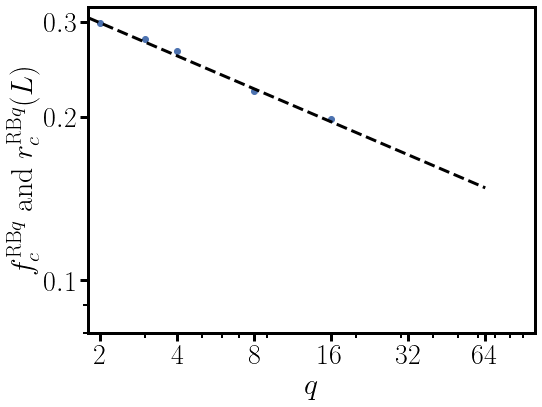

In [71]:
_l_values = []
mean_fc_values = []
for l in range(2, 17):
    attack = f'Btw_cutoff{l}'
    if attack in fc_values:
        try:
            mean_fc, std_fc = fc_values[attack]
        except:
            continue
        
        _l_values.append(l)
        mean_fc_values.append(mean_fc)
        
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_ylabel(r'$f_c^{\mathrm{RB}q}\;\mathrm{and}\; r_c^{\mathrm{RB}q}(L)$')
ax.set_xlabel(r'$q$')
ax.set_xscale('log')
ax.set_yscale('log')

X, Y = _l_values, mean_fc_values
#X = X[:7]
#Y = Y[:7]

Y_pred, slope, y_err = getLinearReg(X, Y)
c = Y[0] / X[0]**slope
label = r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
print('{:.2f}+-{:.2f}'.format(slope, y_err))
#label = r'$f_c^{(\mathrm{RB}\ell)} \sim L^{-\omega}$'
ax.plot(X, Y, 'o', label=r'$f_c^{\mathrm{B}q}$')
#ax.plot(X, Y_pred, '--', color='k', label=label)
x = np.linspace(1, 64)
y = powerlaw(x, slope, c)
ax.plot(x, y, '--', color='k', label=label)


ax.set_xlim(1.8, 100)
ax.set_xticks([2, 4, 8, 16, 32, 64])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylim(0.08, 0.32)
ax.set_yticks([0.1, 0.2, 0.3])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())


_sizes = [
    16384, 
    32768, 65536, 131072
]
for i, size in enumerate(_sizes): 
    if size not in rc_values:
        continue
    L = np.sqrt(size)
    mask = ~np.isnan(rc_values[size][1:])
    
    X = l_values[mask] 

    Y = rc_values[size][1:][mask]
    Y_std = rc_values_std[size][1:][mask]
    
    #ax.plot(l_values, rc_values[size][1:], 'o-', 
    ax.plot(
        X, Y, '--', label=r'${{{}}}$'.format(size)
    )

handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles[2:], labels[2:],
          fontsize=20, loc='lower left')
legend1.set_title(r'$L^2$', prop={'size':22})
ax.add_artist(legend1)
## Lines
ax.legend(handles[:1], labels[:1],
          fontsize=22, loc='upper right', frameon=False)

fig_name = os.path.join(fig_dir, 'f_c_and_r_c_Bl{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

### Phase transition at $q/L=0.25$

In [ ]:
sizes = [512, 1024, 2048, 4096, 8192, 16384]
l_values = np.arange(2, 200)
nseeds = 1000
rc_values, rc_values_std = get_rc_values(
    sizes, l_values=l_values, 
    min_nseeds=100, 
    #nseeds=nseeds,
    base_attack='Btw'
)
l_cutoff = get_l_cutoff(
    sizes, threshold=1e-2, rc_values=rc_values,
    base_attack='Btw'
)
print(l_cutoff)

In [ ]:
net_type = 'DT'
param = 'param'
sizes = [512, 1024, 2048, 4096, 8192, 16384]    
nseeds = 100

l_values = {}
for size in sizes:
    L = np.sqrt(size)
    #l = int(L / 4)
    l = l_cutoff[size] // 4
    l_values[size] = l

nrows = 2
ncols = 1
fig, axes = plt.subplots(figsize=(10*ncols, 5*nrows), nrows=nrows, ncols=ncols)     

dfs = {}
max_means ={}
max_nsec ={}
for i, size in enumerate(sizes):
    l = l_values[size]
    print(size, l)
    attack = f'Btw_cutoff{l}'
    df = load_dataframe(
        net_type, size, param, attack=attack, min_nseeds=nseeds
    )
    max_means[size] = np.max(df.meanS)
    max_nsec[size] = np.max(df.Nsec)
    dfs[size] = df
    
ax = axes[0]
ax.set_ylabel(r'$S_1$')
for i, size in enumerate(sizes):
    df = dfs[size]
    label = attack_dict[attack] if j==0 else ''
    ax.plot(df.f, df.Sgcc, color=f'C{i}', label=label)

ax = axes[1]
ax.set_ylabel(r'$\langle s \rangle$')
for i, size in enumerate(sizes):
    df = dfs[size]
    ax.plot(df.f, df.meanS, color=f'C{i}')



axes[0].legend(
    loc='upper right', fontsize=20
    #oc=(0.9, 0.5)
)
plt.tight_layout()
plt.show()

In [ ]:
def plot_S1_over_S2(net_type):

    ncols = 1
    nrows = 1
    fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

    sizes = [1024, 2048, 4096, 8192, 16384]  

    dfs = {}
    for N in sizes:
        l = l_values[N]
        attack = f'Btw_cutoff{l}'
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
        except FileNotFoundError:
            continue

    N_values = np.sort(list(dfs.keys()))
    L_values = np.sqrt(N_values)

    dfs = {N: dfs[N] for N in N_values}

    fmin = 0.1
    fmax = 0.3
    ymin = 1.
    ymax = 10.     

    ax.set_xlim(fmin, fmax)
    ax.set_ylim(ymin, ymax)

    ax.set_ylabel(r'$S_1/S_2$', fontsize=28)
    ax.set_xlabel(r'$f$', fontsize=28)

    colors = sns.cubehelix_palette(
        len(N_values), start=2, rot=0.3, 
        light=0.8, dark=0.1
    )
    for i, N in enumerate(N_values):
        df = dfs[N]
        S1_over_S2 = N * df.Sgcc / df.Nsec
        ax.plot(df.f, S1_over_S2, '-', label=r'${{{}}}$'.format(N), color=colors[i])

    mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=False, verbose=False)
    print('{:20}{:.5f} +- {:.5f}{:10f}'.format(attack, mean_fc, std_fc, std_fc/mean_fc))

    ax.axvline(mean_fc, linestyle='--', color='k', linewidth=2)
    ax.fill_betweenx([ymin, ymax], mean_fc-std_fc, mean_fc+std_fc, color='k', alpha=0.3)
    ax.legend(loc='best', fontsize=24)

    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'crossing_method_l_over_L_constant_' + net_type)
    plt.savefig(fig_name + '.png', transparent=False)
    plt.savefig(fig_name + '.pdf')
    
    plt.show()
    
    return fc_values
    
net_type = 'DT'
fc_values = plot_S1_over_S2(net_type=net_type)

### IB2 attack

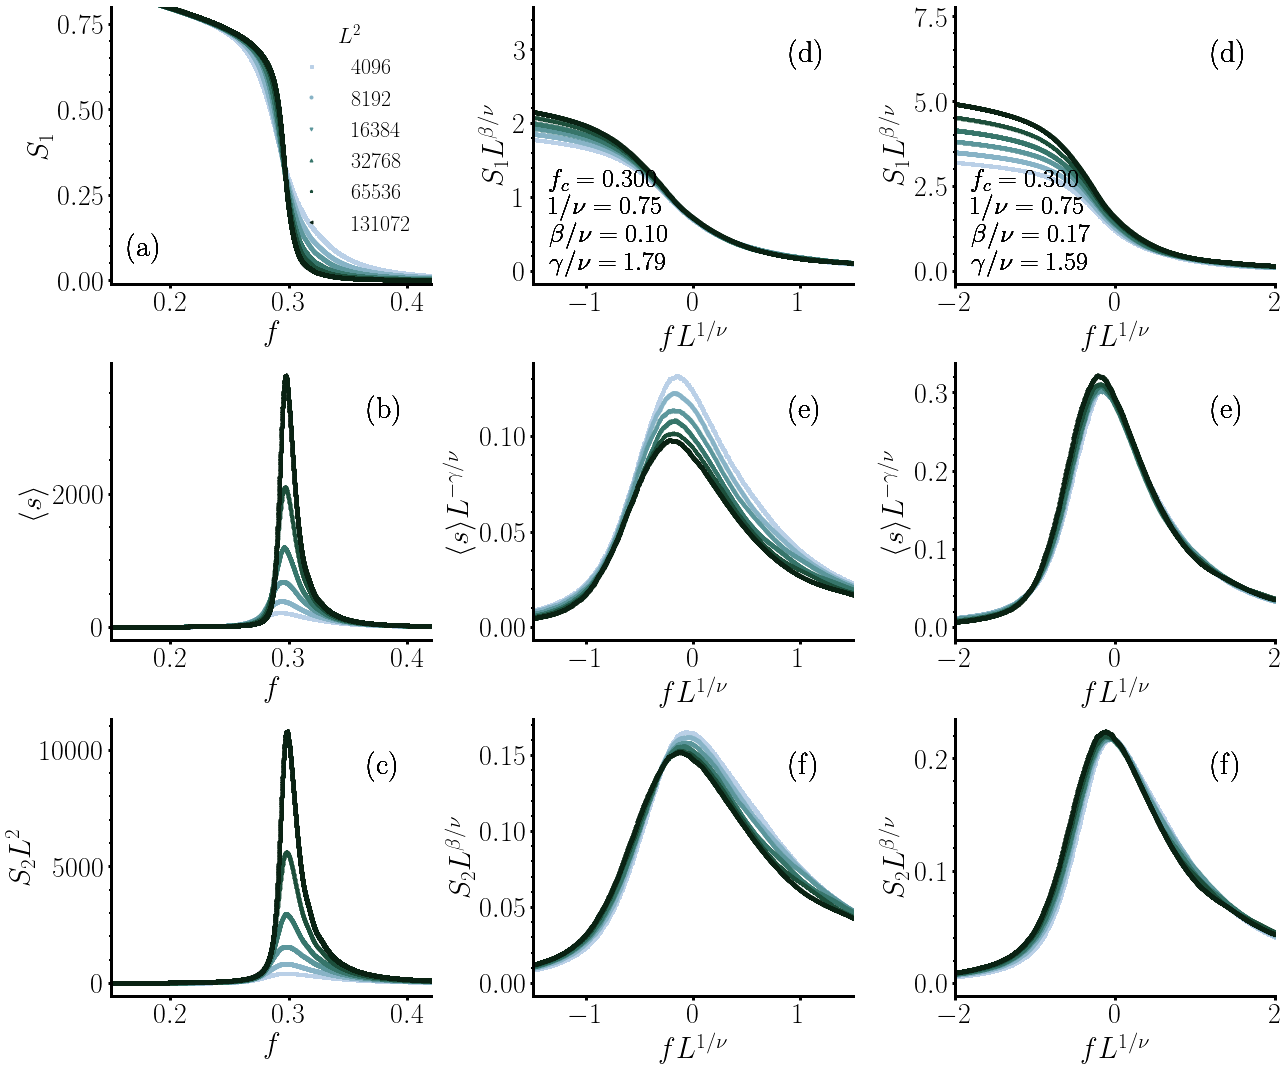

In [56]:
attack = 'Btw_cutoff2'
#attack = 'DegU'
sizes = [4096, 8192, 16384, 32768, 65536, 131072]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=10000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 3
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
for ax in axes[:,0]:
    ax.set_xlim(0.15, 0.42)
    ax.set_xticks([0.2, 0.3, 0.4])
    ax.set_xlabel(r'$f$')
for ax in axes[:,1]:
    ax.set_xlim(-1.5, 1.5)
    ax.set_xlabel(r'$f L^{1/\nu}$')
for ax in axes[:,2]:
    ax.set_xlim(-2, 2)
    ax.set_xlabel(r'$f L^{1/\nu}$')
    
ax = axes[0,0]
ax.set_ylabel(r'$S_1$')
ax = axes[1,0]
ax.set_ylabel(r'$\langle s\rangle$')
ax = axes[2,0]
ax.set_ylabel(r'$S_2L^2$')

for i in [1, 2]:
    ax = axes[0,i]
    ax.set_ylabel(r'$S_1 L^{\beta/\nu}$')
    ax = axes[1,i]
    ax.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$')
    ax = axes[2,i]
    ax.set_ylabel(r'$S_2 L^{\beta/\nu}$')
        
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    ax.set_ylim(-0.01, 0.8)
    ax.text(0.05, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = axes[1,0]
    ax.text(0.8, 0.8, letters[1], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.meanS, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    ax = axes[2,0]
    ax.text(0.8, 0.8, letters[2], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.Nsec, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    
for j in [1, 2]:
    if j == 1:
        one_over_nu = 0.75
        gamma_over_nu = 1.792
        beta_over_nu = 0.104
    else:
        one_over_nu = 0.75
        gamma_over_nu = 1.59
        beta_over_nu = 2 - 1.83
    fc = 0.29965
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        L = np.sqrt(N)

        ax = axes[0,j]
        ax.text(0.8, 0.8, letters[3], transform=ax.transAxes, fontsize=30)

        ax.plot((df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
        ax.text(
            0.05, 0.35, r'$f_c = {{{:.3f}}}$'.format(fc), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.25, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.15, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.05, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), 
            transform=ax.transAxes, fontsize=26
        )

        ax = axes[1,j]
        ax.text(0.8, 0.8, letters[4], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )  

        ax = axes[2,j]
        ax.text(0.8, 0.8, letters[5], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.Nsec*L**(beta_over_nu-2), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )

legend = axes[0,0].legend(loc='upper right', fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_Bl2_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

ValueError: too many values to unpack (expected 5)

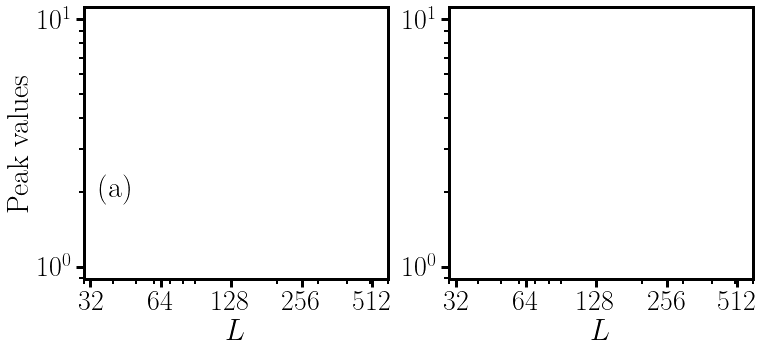

In [7]:
attack = 'Btw_cutoff2'
measures = ['meanS', 'Nsec']

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(30, 600)
    ax.set_xticks([32, 64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]

ax.text(0.05, 0.3, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):

    L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    

    if measure == 'meanS':
        label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label1 = label
        line1, = ax.plot(L_values, Y_pred, '--', color='grey', label=label)

    elif measure == 'Nsec':
        label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label2 = label
        line2, = ax.plot(L_values, Y_pred, '-.', color='k', label=label)            

    markers1, = ax.plot(
        L_values, measure_values, marker_dict[measure], 
        color=color_dict[measure], markersize=8, 
        label=label_dict[measure]
    )

handles, labels = ax.get_legend_handles_labels()
## Markers
order = [1, 3]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.6, 0.05))

ax.add_artist(legend1)
## Lines
order = [2, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.0, 0.73), frameon=False)

#########################################################

dfs = {}
for N in sizes:
    print(N)
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

ax = axes[1]
fc = fc_values[attack]
ax.text(0.05, 0.3, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$f_c-f_c(L)$')
for i, measure in enumerate(measures):
        
    X = L_values
    Y, _ = getPeaks(dfs, measure)
    print(Y)
    Y = fc - np.array(Y)
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[0] / X[0]**slope
    label = r'$1/\nu = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err)
    ax.plot(X, Y_pred, linestyle_dict[measure], color=line_colors[measure], label=label)
    ax.plot(X, Y, marker_dict[measure], markersize=8, label=measures_dict[measure])
    
handles, labels = ax.get_legend_handles_labels()

## Lines
order = [0, 2]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.25, 0.73), frameon=False)

#ax.set_ylim(0.07, 0.13)
#ax.set_yticks([0.08, 0.1, 0.12])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.text(0.05, 0.1, r'$f_c={{{}}}$'.format(fc), fontsize=26, transform=ax.transAxes)    

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'beta_gamma_nu_scaling_Bl2_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [15]:
from collections import defaultdict
all_comp_sizes = defaultdict(dict)
nseeds_values = defaultdict(dict)

In [23]:
attacks = [
    'Ran', 
    'Btw_cutoff2', 
    #'Btw_cutoff3', 
    'Btw_cutoff4',
    'Btw_cutoff8',
    'Btw_cutoff16',
    #'Btw_cutoff31'
]
sizes = [4096]
ndrop = 1

f_values_dict = { 
    'Ran': {
        4096: ['-', '0.51270', '-'],
        65536: ['-', '0.50371', '-'],
        131072: ['-', '0.50371', '0.50433', '0.50000'],
    },
    'Btw_cutoff2': {
        4096: ['-', '0.29248', '-'],
        65536: ['-', '0.29681', '-'],
        131072: ['-', '0.29683', '-'],
    },
    'Btw_cutoff3': {
        4096: ['-', '0.51270', '-'],
        131072: ['-', '0.27724', '-'],
    },
    'Btw_cutoff4': {
        4096: ['-', '0.25781', '-'],
        65536: ['-', '0.26225', '-'],
        131072: ['-', '0.26305', '-'],
    },
    'Btw_cutoff8': {
        4096: ['-', '0.21582', '-'],
        65536: ['-', '0.22476', '-'],
    },
    'Btw_cutoff16': {
        4096: ['-', '0.17090', '-'],
        65536: ['-', '0.19931', '-'],
    },
    'Btw_cutoff31': {
        4096: ['-', '0.11865', '-'],
    }
}

for attack in attacks:
    print(attack)
    for N in sizes:
        print(N)
        f_value = f_values_dict[attack][N][1]
        if N in all_comp_sizes[attack]:
            continue
        net_dir_name = NETWORKS_DIR / 'DT' / f'DT_{param}'
        base_net_name = f'DT_param_N{N}'
        base_net_dir_name = net_dir_name / base_net_name
        base_file_name =  f'comp_sizes_{attack}_f{f_value}_drop{ndrop}'
        comp_sizes_file = base_net_dir_name / (base_file_name + '.txt')
        seeds_file = base_net_dir_name / (base_file_name + '_seeds.txt')
        comp_sizes = np.loadtxt(comp_sizes_file, dtype=int)
        try:
            nseeds = len(np.loadtxt(seeds_file, dtype=int))
        except:
            nseeds = 1
        nseeds_values[attack][N] = nseeds
        all_comp_sizes[attack][N] = comp_sizes

print(nseeds_values)

Ran
4096
Btw_cutoff2
4096
Btw_cutoff4
4096
Btw_cutoff8
4096
Btw_cutoff16
4096
defaultdict(<class 'dict'>, {'Ran': {65536: 1000, 4096: 10000}, 'Btw_cutoff2': {65536: 1000, 4096: 6000}, 'Btw_cutoff4': {65536: 999, 4096: 10000}, 'Btw_cutoff8': {65536: 1000, 4096: 10000}, 'Btw_cutoff16': {65536: 1000, 4096: 10000}})


[    1     2     3 ... 10028 10135 11161] [1.17883301e-02 3.97422791e-03 1.99357605e-03 ... 1.52587891e-08
 1.52587891e-08 1.52587891e-08]
1 2 0.011788330078125
2 4 0.005967803955078125
4 8 0.0030140228271484377
8 16 0.0015246582031250002
16 32 0.0007748107910156251
32 64 0.0004006500244140625
64 128 0.000203338623046875
128 256 0.00010359191894531254
256 512 5.541992187500001e-05
512 1024 3.0502319335937505e-05
1024 2048 1.8844604492187505e-05
2048 4096 1.2298583984375e-05
4096 8192 7.476806640625e-06
8192 16384 7.476806640625e-07
16384 32768 0.0
32768 65536 0.0


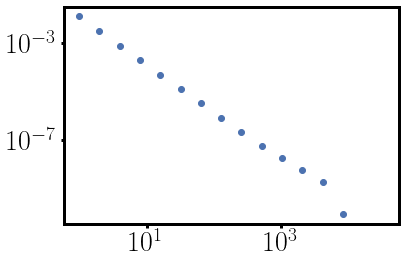

In [56]:
sizes, counts = np.unique(comp_sizes, return_counts=True)
counts = counts / (N*nseeds)
print(sizes, counts)
ser = pd.Series(np.zeros(N))
ser[sizes] = counts
ser

bins = 2**np.arange(0, np.log2(N)+1)
bins = bins.astype('int')
bin_left = bins[:-1]
bin_width = np.diff(bins)
bin_width

freqs = np.zeros(len(bin_width), dtype='float')
for i in range(len(freqs)):
    left = bins[i]
    right = bins[i+1]
    s = ser.values[left:right].sum()
    print(left, right, s)
    freqs[i] = s / bin_width[i]
    
plt.xscale('log')
plt.yscale('log')
plt.plot(bin_left, freqs, 'o')

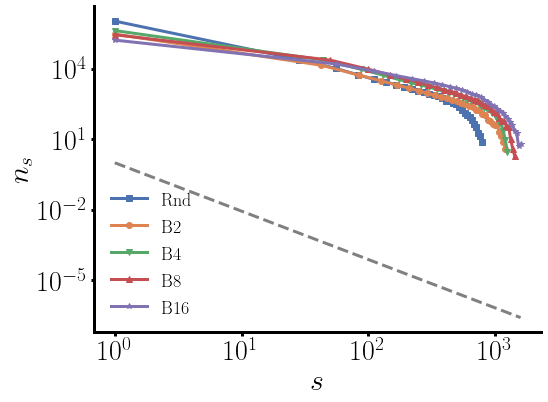

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$n_s$')

for i, attack in enumerate(attacks):
    comp_sizes = all_comp_sizes[attack][N]
    #bins = np.logspace(0, np.log10(comp_sizes.max()+1), 20)
    bins = 30
    freq, bin_edges = np.histogram(comp_sizes, bins=bins, density=False)

    X = bin_edges[:-1] #/ N
    Y = freq
    
    mask = (Y>0)
    X = X[mask]
    Y = Y[mask]
    
    Y_pred, slope, Y_err = getLinearReg(X[:-1], Y[:-1])
    c = Y_pred[5] / X[5]**slope
    ax.plot(
        X, Y, f'-{markers[i]}', 
        #fillstyle='none', 
        label=attack_dict[attack]
           )
    label = r'$\tau = {{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*Y_err)
    #ax.plot(X, powerlaw(X, slope, c), '--k', label=label)
    
c = 1e-7
c = 1e-9
c = 1
ax.plot(
    X, powerlaw(X, -2.055, c), '--', color='gray',
    #label=r'$2.055$'
)
"""
ax.plot(bin_left, freqs, 's')
ax.plot(
    bin_left, powerlaw(bin_left, -2.055, 1e-2), '-', color='gray',
    #label=r'$2.055$'
)
"""
ax.legend(frameon=False, fontsize=18)
sns.despine()

fig_name = os.path.join(fig_dir, 'comp_sizes_Bl_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [122]:
nseeds_values = {}
all_comp_sizes = {}

In [123]:
#N = 65536
N = 262144
ndrop = 1
attack = 'Ran'
f_values = [
    '0.49700', '0.49800', 
    '0.49900',
    '0.50000', 
    '0.50100', 
    '0.50200', 
    '0.50300', 
    '0.50400', 
    '0.50500', 
    '0.50600', '0.50700'
]
net_dir_name = NETWORKS_DIR / 'DT' / f'DT_{param}'
base_net_name = f'DT_param_N{N}'
base_net_dir_name = net_dir_name / base_net_name
for f_value in f_values:
    if f_value in all_comp_sizes:
        continue
    base_file_name =  f'comp_sizes_{attack}_f{f_value}_drop{ndrop}'
    comp_sizes_file = base_net_dir_name / (base_file_name + '.txt')
    seeds_file = base_net_dir_name / (base_file_name + '_seeds.txt')
    try:
        comp_sizes = np.loadtxt(comp_sizes_file, dtype=int)
    except:
        continue
    try:
        nseeds = len(np.loadtxt(seeds_file, dtype=int))
    except:
        nseeds = 1
    nseeds_values[f_value] = nseeds
    all_comp_sizes[f_value] = comp_sizes

f_values = list(all_comp_sizes.keys())
print(nseeds_values)

{'0.49800': 200, '0.49900': 200, '0.50000': 100, '0.50100': 200, '0.50200': 100, '0.50300': 100, '0.50400': 100}


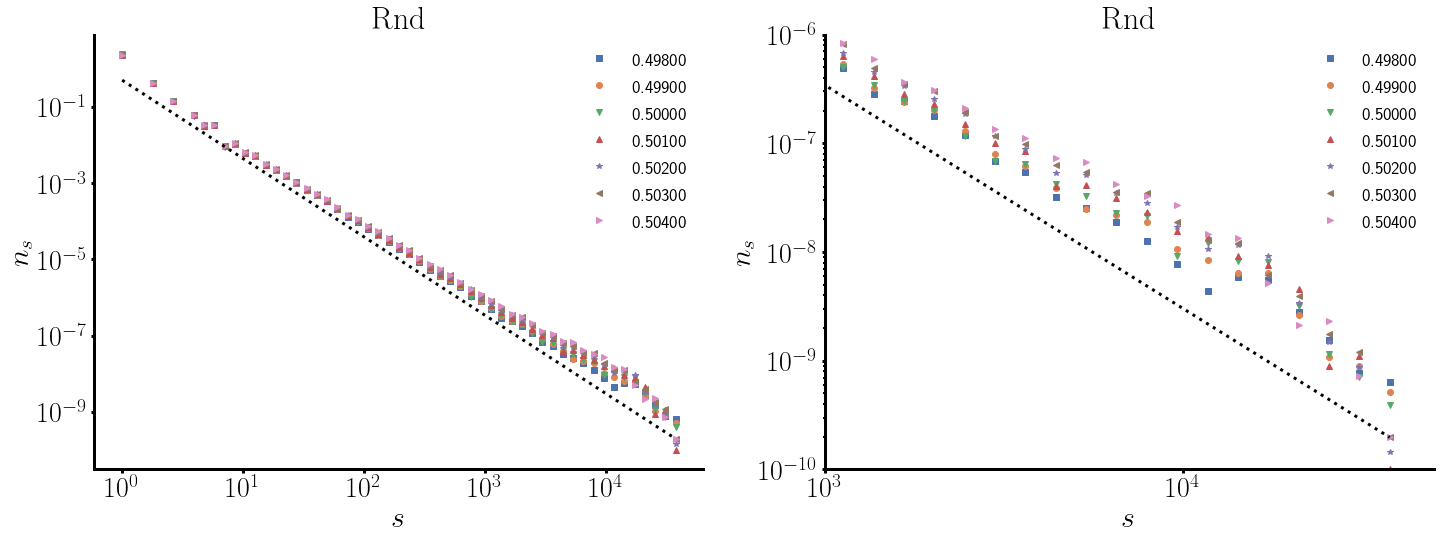

In [124]:
ncols = 2
fig, axes = plt.subplots(figsize=(12*ncols,8), ncols=ncols)
for i, ax in enumerate(axes):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$s$')
    ax.set_ylabel(r'$n_s$')
    ax.set_title(attack_dict[attack], fontsize=32)
    if i == 1:
        ax.set_xlim(1e3, 5e4)
        ax.set_ylim(1e-10, 1e-6)
    for i, f_value in enumerate(f_values):
        comp_sizes = all_comp_sizes[f_value]
        #bins = np.logspace(0, np.log10(comp_sizes.max()+1), 30)
        
        bins = np.logspace(0, 5, 60)
        freq, bin_edges = np.histogram(comp_sizes, bins=bins, density=True)
        X = bin_edges[:-1] 
        #print(X)
        Y = freq

        mask = (Y>0)
        X = X[mask]
        Y = Y[mask]

        Y_pred, slope, Y_err = getLinearReg(X[:-1], Y[:-1])
        c = Y_pred[5] / X[5]**slope
        ax.plot(
            X, Y, 
            #f'--{markers[i]}',
            markers[i],
            label=f_value
        )
        label = r'$\tau = {{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*Y_err)
    c = 0.5
    ax.plot(X, powerlaw(X, -2.055, c), ':', color='k')
    #ax.plot(X, powerlaw(X, -1.8, c), ':', color='k')

    ax.legend(frameon=False, fontsize=18)
sns.despine()
plt.show()

In [10]:
attack = 'Btw_cutoff4'

sizes = np.array([
    1024, 2048, 4096, 8192, 16384, 32768, 65536#, 131072
                 ])
_sizes = []
all_mean_values = []
all_std_values = []
nseeds_values = []
fluctuations = {}
for i, N in enumerate(sizes):
    try:
        delta_values, nseeds = load_delta(net_type, N, param, attack, min_nseeds=10000, return_nseeds=True)
        _sizes.append(N)
    except FileNotFoundError:
        print(N)
        continue
         
    nseeds_values.append(nseeds)
    
    delta_values[:,2] = delta_values[:,2]*N
    mean_values = delta_values.mean(axis=0)
    std_values = delta_values.std(axis=0)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    fluctuations[N] = delta_values - mean_values
    
all_mean_values = np.array(all_mean_values)
all_std_values = np.array(all_std_values)
nseeds_values = np.array(nseeds_values)

rc_values = all_mean_values[:,0]
delta_values = all_mean_values[:,1]

sizes = np.array(_sizes)   
print(sizes, rc_values)

1024
16384
[ 2048  4096  8192 32768 65536] [0.25010938 0.25328777 0.25613077 0.25969092 0.26076493]


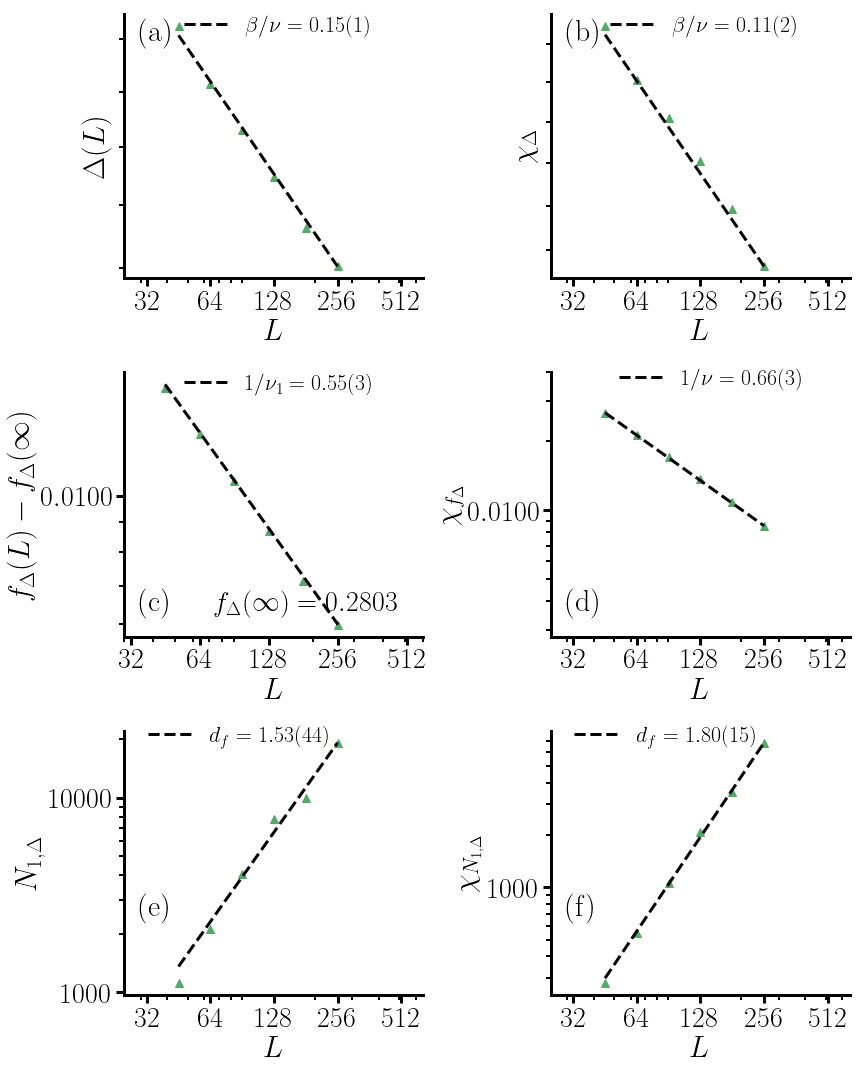

In [32]:
attack = 'Btw_cutoff3'

ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(25, 650)
    ax.set_xticks([32, 64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0,0]
#ax.set_ylim(0.27, 0.30)
ax.text(0.05, 0.9, letters[0], transform=ax.transAxes, fontsize=30)
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\Delta (L)$')
X = np.sqrt(sizes)
Y = all_mean_values[:,1]
Y_err = np.sqrt(all_std_values[:,1]/nseeds_values)
ax.plot(X, Y, '^', color='C2', markersize=8)
#ax.errorbar(X, Y, Y_err, marker='^', color='C2', markersize=8)
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
label = label=r'$\beta/\nu={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err)
label = label=r'$\beta/\nu={{{:.2f}}}({{{:.0f}}})$'.format(-slope, 100*y_err)
ax.plot(X, powerlaw(X, slope, c), '--', color='k', label=label)
ax.legend(fontsize=22, loc=(0.17, 0.88), frameon=False)
###################################################################

ax = axes[1,0]
ax.text(0.05, 0.1, letters[2], transform=ax.transAxes, fontsize=30)
#ax.set_ylim(0.04, 0.2)
#ax.set_yticks([0.05, 0.1, 0.15])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylabel(r'$f_{\Delta}(L) - f_{\Delta}(\infty)$')
rc = fc_values[attack][0]
X = np.sqrt(sizes)
Y = rc - all_mean_values[:,0]
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = r'$1/\nu_1={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err)
label = r'$1/\nu_1={{{:.2f}}}({{{:.0f}}})$'.format(-slope, 100*y_err)
ax.plot(X, powerlaw(X, slope, c), '--', color='k', label=label)
ax.legend(fontsize=22, loc=(0.17, 0.88), frameon=False)
ax.set_xlim(30, 600)
ax.set_xticks([32, 64, 128, 256, 512])
ax.text(0.3, 0.1, r'$f_{\Delta}$' + r'$(\infty)={{{:.4f}}}$'.format(rc), fontsize=28, transform=ax.transAxes)
sns.despine()

#############################################################


ax = axes[0,1]
#ax.set_ylim(0.07, 0.085)
ax.text(0.05, 0.9, letters[1], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.04, 0.072])
#ax.set_yticks([0.04, 0.05, 0.06, 0.07])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{\Delta}$')
Y = all_std_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
beta_over_nu = -slope
ax.plot(X, Y, '^', color='C2', markersize=8)
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
label = label=r'$\beta/\nu={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err)
label = label=r'$\beta/\nu={{{:.2f}}}({{{:.0f}}})$'.format(-slope, 100*y_err)
ax.plot(X, powerlaw(X, slope, c), '--', color='k', label=label)
ax.legend(fontsize=22, loc=(0.17, 0.88), frameon=False)
###############################################################

ax = axes[1,1]
ax.text(0.05, 0.1, letters[3], transform=ax.transAxes, fontsize=30)
ax.set_ylim([0.0028, 0.04])
#ax.set_yticks([0.003, 0.01, 0.03])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{f_{\Delta}}$')
Y = all_std_values[:,0]

Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = label=r'$1/\nu={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err)
label = label=r'$1/\nu={{{:.2f}}}({{{:.0f}}})$'.format(-slope, 100*y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend(fontsize=22, loc=(0.2, 0.9), frameon=False)

######################################################################

ax = axes[2,0]
ax.text(0.05, 0.3, letters[4], transform=ax.transAxes, fontsize=30)
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$N_{1,{\Delta}}$')
Y = all_mean_values[:,2]
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = label=r'$d_f={{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
label = label=r'$d_f={{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

###############################################################

ax = axes[2,1]
ax.text(0.05, 0.3, letters[5], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.002, 0.04])
#ax.set_yticks([0.003, 0.01, 0.03])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{N_{1,\Delta}}$')
Y = all_std_values[:,2]
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = label=r'$d_f = {{{:.2f}}}\pm {{{:.0f}}}$'.format(slope, y_err)
label = label=r'$d_f = {{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

################################################################

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B2_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

## Fotos

1.0
start plot
Plot backbone
Plot removed
(1230, 2)
Plot components
start scatter


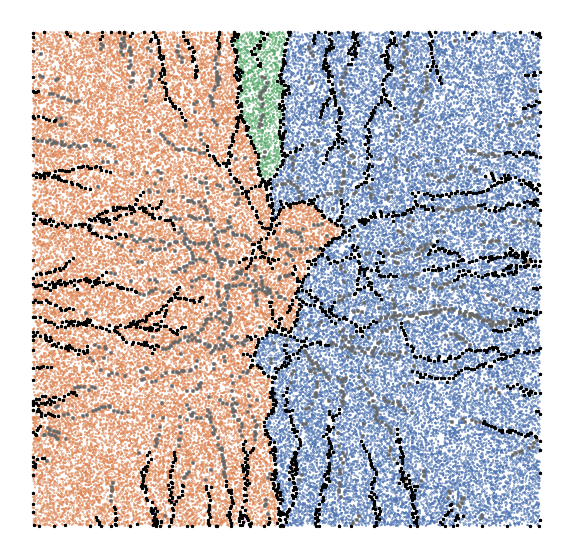

In [9]:
def get_label_dict(g):

    components = g.components(mode='WEAK')
    gcc = components.giant()
    membership = np.array(components.membership)
    number, count = np.unique(membership, return_counts=True)
    number = number[np.argsort(count)[::-1]] 
    label_dict = {i: n for i, n in enumerate(number)}
    reverse_label_dict = {n: i for i, n in enumerate(number)}
    
    return label_dict, reverse_label_dict, membership
    
L = 256
size = L*L
attack = 'Btw'
network = 'DT'
seed = 0

marker_sizes = {
    32: {
        'backbone': 80,
        'removed': 60,
        'components': 40
    },
    64: {
        'backbone': 30,
        'removed': 20,
        'components': 15
    },
    128: {
        'backbone': 20,
        'removed': 10,
        'components': 6
    },
    256: {
        'backbone': 5,
        'removed': 3,
        'components': 1
    },
    512: {
        'backbone': 3,
        'removed': 1,
        'components': 0.1
    },
}

s0 = marker_sizes[L]['backbone']
s1 = marker_sizes[L]['removed']
s2 = marker_sizes[L]['components']

for a in np.arange(1.0, 1.01, 0.1):
    print(a)
    ## Spanning subgraph of the removed nodes
    h, max_pos, _ = load_delta_data(network, size, param, attack, seed)
    th = int(a*max_pos)+1

    attack_order = h['attack_order']
    to_delete = set(h.vs['oi']).difference(set(attack_order[:th]))
    h.delete_vertices(to_delete)

    backbone_label_dict, _, backbone_membership = get_label_dict(h)

    backbone_index_dict = {oi: i for i, oi in enumerate(h.vs['oi'])}

    ################

    _colors = [f'C{i}' for i in range(1000)] #+ 10000*['white']
    g, _, _ = load_delta_data(network, size, param, attack, seed)    
    position = np.array(g.vs['position'])
    attack_order = g['attack_order']
    to_delete = set(g.vs['oi']).difference(set(attack_order[th:]))
    g.delete_vertices(to_delete)

    label_dict, reverse_label_dict, membership = get_label_dict(g)

    index_dict = {oi: i for i, oi in enumerate(g.vs['oi'])}

    if False:
        attack_order = g['attack_order']
        g.delete_vertices(attack_order[:th])

        components = g.components(mode='WEAK')
        gcc = components.giant()
        membership = np.array(components.membership)
        number, count = np.unique(membership, return_counts=True)
        number = number[np.argsort(count)[::-1]] 
        count = np.sort(count)[::-1]

        label_dict = dict((i, n) for i,n in enumerate(number))
        for idx in np.where(count==1)[0]:
            label_dict[idx] = -1

    print('start plot')

    def plot_backbone():
        _position = []
        for oi in attack_order[:th]:
            #idx = h.vs['oi'].index(oi)
            idx = backbone_index_dict[oi]
            #if backbone_label_dict[backbone_membership[idx]] == 0:
            if backbone_membership[idx] == backbone_label_dict[0]:
                _position.append(position[oi])
        _position = np.array(_position)
        X, Y = _position[:,0], _position[:,1]
        plt.scatter(X, Y, c='k', marker='*', s=s0, zorder=10)

    def plot_removed():
        _position = []
        for oi in attack_order[:th]:
            #idx = h.vs['oi'].index(oi)
            idx = backbone_index_dict[oi]
            if backbone_membership[idx] != backbone_label_dict[0]:
                _position.append(position[oi])
        _position = np.array(_position)
        print(_position.shape)
        X, Y = _position[:,0], _position[:,1]
        plt.scatter(X, Y, c='0.4', marker='s', s=s1, zorder=5)

    def plot_components():
        _position = position[attack_order[th:]]
        X, Y = _position[:,0], _position[:,1]
        c_values = []

        for oi in attack_order[th:]:
            idx = index_dict[oi]
            c_values.append(
                #_colors[reverse_label_dict[membership[idx]]]
                'C{}'.format(reverse_label_dict[membership[idx]]%100)
            )
        print('start scatter', flush=True)
        plt.scatter(
            X, Y, c=c_values, marker='.', s=s2, zorder=0
        )

    def save_fig():
        fig_name = os.path.join(fig_dir, 'breaking_nodes_{}_L{}_{}_{:05d}_th{}_backbone'.format(network, L, attack, seed, th))
        dpi = 100
        plt.savefig(fig_name + '.png', transparent=False, dpi=dpi)
        plt.savefig(fig_name + '.pdf', dpi=dpi)

    fig, ax = plt.subplots(figsize=(10,10))
    #mpl.style.use('default')
    #ax.set_xlabel(r'$x$')
    #ax.set_ylabel(r'$y$')
    #ax.set_xlim(0, L)
    #ax.set_ylim(0, L)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.margins()
    ax.set_facecolor('white')
    sns.despine(bottom=True, left=True)
    print('Plot backbone')
    plot_backbone()
    print('Plot removed')
    plot_removed()
    print('Plot components')
    plot_components()
    save_fig()

    plt.show()

In [15]:
attack = 'Btw'

sizes = np.array([
    #256, 
    #512, 1024, 2048, 4096, 
    #8192, 16384, 32768, 
    65536, 
    #131072, 
    #262144
])

nseeds_values = {
    512: 10000,
    1024: 10000,
    2048: 10000,
    4096: 10000,
    8192: 10000,
    16384: 10000,
    32768: 10000,
    65536: 10000,
    131072: 1600,
}
n_deltas = 256
rc_values = {}
delta_values = {}
for i, N in enumerate(sizes):
    try:
        pos_and_delta = load_deltas(
            net_type, N, param, attack, nseeds=nseeds_values[N], n_deltas=n_deltas
        )
    except FileNotFoundError:
        print(N)
        raise

    mean_values = pos_and_delta.mean(axis=0)
    std_values = pos_and_delta.std(axis=0)
    
    rc_values[N] = mean_values[::2]
    delta_values[N] = mean_values[1::2]

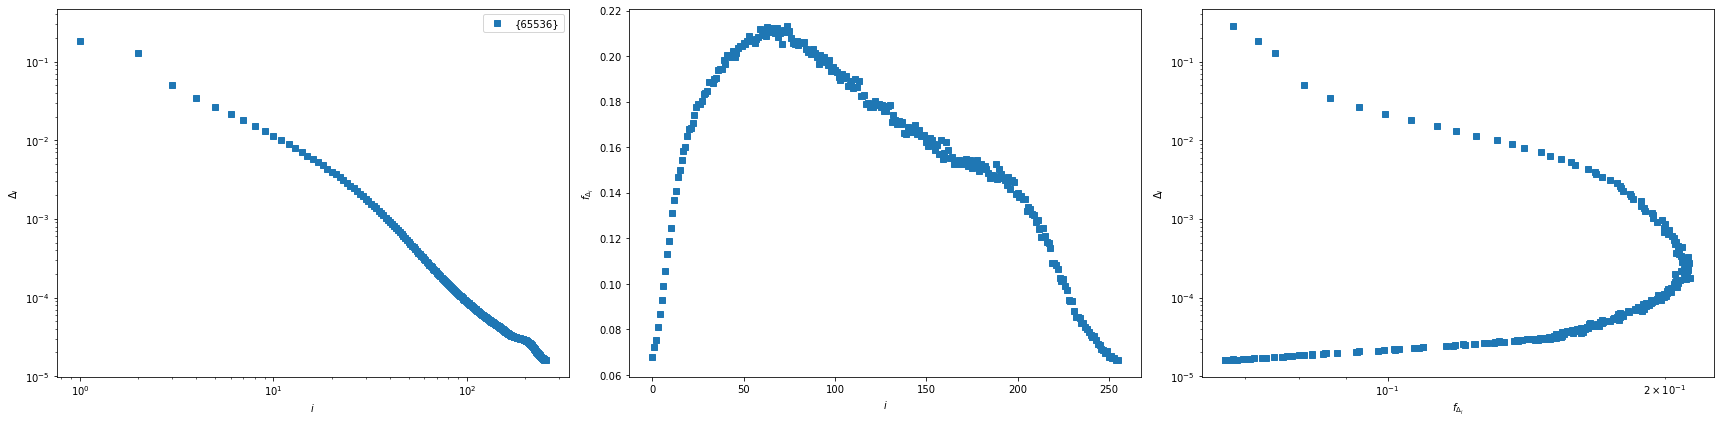

In [18]:
ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    ax.plot(delta_values[N], markers[i], label=r'{{{}}}'.format(N))
ax.legend()

ax = axes[1]
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$f_{\Delta_i}$')
for i, N in enumerate(sizes):
    ax.plot(rc_values[N], markers[i])
    
ax = axes[2]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$f_{\Delta_i}$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    ax.plot(rc_values[N], delta_values[N], markers[i])

plt.tight_layout()
plt.show()

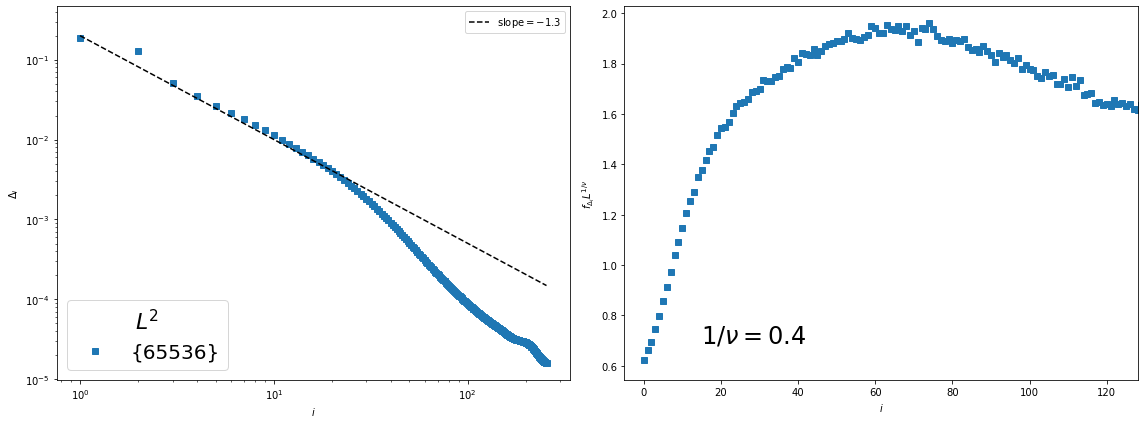

In [19]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    ax.plot(delta_values[N], markers[i], label=r'{{{}}}'.format(N))

X = np.arange(1, n_deltas, dtype=float)
slope=-1.3
c=0.2*1e0
label = r'$\mathrm{slope}$' + '$ = {{{}}}$'.format(slope)
ax.plot(X, powerlaw(X, slope, c), '--', color='k', label=label)    
    
handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles[:-1], labels[:-1],
          fontsize=20, loc='lower left')
legend1.set_title(r'$L^2$', prop={'size':22})
ax.add_artist(legend1)

ax.legend(handles[-1:], labels[-1:])

ax = axes[1]
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$f_{\Delta_i}L^{1/\nu}$')
ax.set_xlim(-5, 128)
one_over_nu = 0.4
for i, N in enumerate(sizes):
    L = np.sqrt(N)
    ax.plot(rc_values[N]*L**(one_over_nu), markers[i])
text = r'$1/\nu={{{}}}$'.format(one_over_nu)
ax.text(0.15, 0.1, text, transform=ax.transAxes, fontsize=24)

X = np.arange(1, 30)
a = 0.05
b = 0.5
Y = a*X+b
#ax.plot(X, Y, linestyle=':', color='gray')
plt.tight_layout()
plt.show()

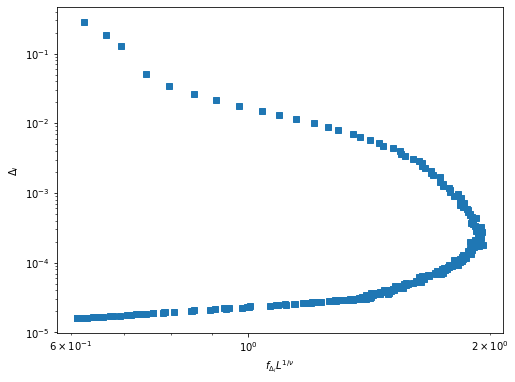

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$f_{\Delta_i}L^{1/\nu}$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    L = np.sqrt(N)
    ax.plot(rc_values[N]*L**one_over_nu, delta_values[N], markers[i])
plt.show()

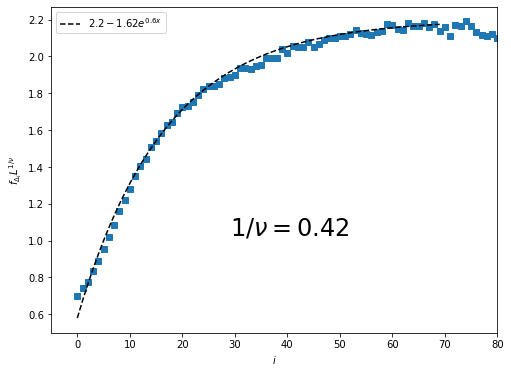

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$f_{\Delta_i}L^{1/\nu}$')
ax.set_xlim(-5, 80)
#ax.set_yscale('log')
one_over_nu = 0.42
for i, N in enumerate(sizes):
    L = np.sqrt(N)
    ax.plot(rc_values[N]*L**(one_over_nu), markers[i])
text = r'$1/\nu={{{}}}$'.format(one_over_nu)
ax.text(0.4, 0.3, text, transform=ax.transAxes, fontsize=24)

def func(x, a, b, c):
    return b-c*np.exp(-a*x)
X = np.arange(0, 70)
a = .06
b = 2.2
c = 1.62
Y = func(X, a, b, c)
label = r'${{{}}}-{{{}}}$'.format(b, c) + r'$e^{0.6 x}$'
plt.plot(X, Y, '--', color='k', label=label)
ax.legend()

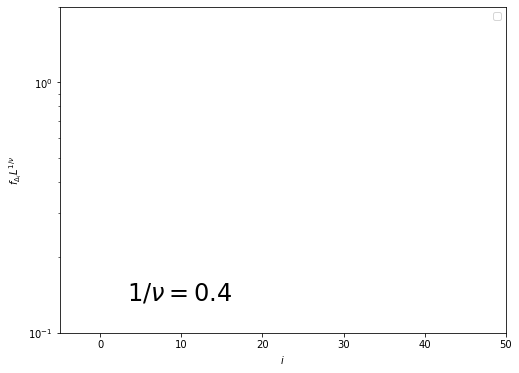

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$f_{\Delta_i}L^{1/\nu}$')
ax.set_xlim(-5, 50)
ax.set_ylim(1e-1, 2)
ax.set_yscale('log')
one_over_nu = 0.4
for i, N in enumerate(sizes[3:4]):
    L = np.sqrt(N)
    ax.plot(2-rc_values[N]*L**(one_over_nu), markers[i], label=N)
text = r'$1/\nu={{{}}}$'.format(one_over_nu)
ax.text(0.15, 0.1, text, transform=ax.transAxes, fontsize=24)
ax.legend()

In [23]:
sizes = np.array(list(delta_values.keys()))
L_values = np.sqrt(sizes)
deltas = np.array([
    v for v in delta_values.values()
]).T
rcs = np.array([
    v for v in rc_values.values()
]).T

NameError: name 'deltas' is not defined

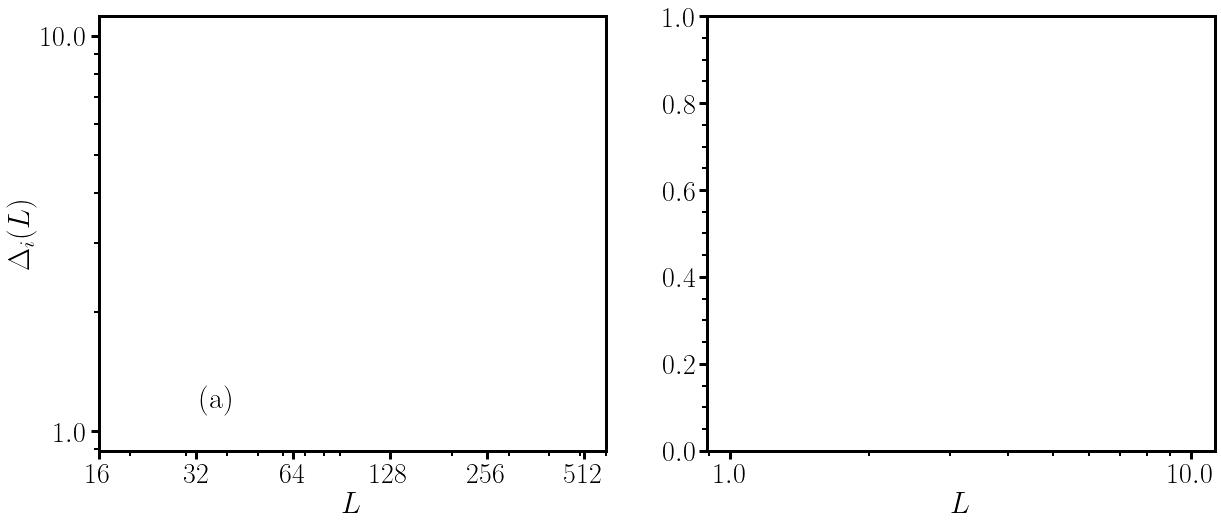

In [43]:
attack = 'Btw'
n_deltas_plot = 8

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]
ax.set_yscale('log')
ax.set_xlim(30, 600)
ax.set_xticks([16, 32, 64, 128, 256, 512])
ax.text(0.2, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\Delta_i(L)$')

for i in range(n_deltas_plot):
    X = L_values
    Y = deltas[i]
    ax.plot(
        X, 
        Y,
        #deltas[i]/deltas[i][-1], 
        '^-', markersize=8,# label=f'{i}'
    )
    Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
    c = Y[-1] / X[-1]**slope
    ax.plot(
        X, powerlaw(X, slope, c), '--', color=f'C{i}', 
        label=r'${{{}}} - \beta/\nu={{{:.3f}}}\pm{{{:.3f}}}$'.format(i, -slope, y_err)
    )
    
ax.legend()


ax = axes[1]
ax.set_yscale('log')
ax.text(0.2, 0.1, letters[1], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.048, 0.12])
#ax.set_yticks([0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\Delta_i}(L) - f_c$')
ax.set_xlim(30, 600)
ax.set_xticks([16, 32, 64, 128, 256, 512])


rc = 0.0
for i in range(n_deltas_plot):
    ax.plot(L_values, rcs[i]-rc, '^-', markersize=8)
    #Y_pred, slope, y_err = getLinearReg(X, Y)
    #ax.plot(X, Y_pred, '--', color='k', label=r'$1/\nu_1={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err))
ax.text(0.1, 0.25, r'$f_c={{{}}}$'.format(rc), fontsize=28, transform=ax.transAxes)

sns.despine()
plt.tight_layout()
#fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B_{}'.format(net_type))
#plt.savefig(fig_name + '.png')
#plt.savefig(fig_name + '.pdf')

plt.show()

In [25]:
attack = 'Ran'

sizes = np.array([
    #256, 512, 
    1024, 2048, 4096, 
    8192, 
    16384, 
    32768, 
    #65536, 
    #131072, 
    #262144
])

nseeds_values = {
    1024: 10000,
    2048: 10000,
    4096: 10000,
    8192: 10000,
    16384: 10000,
    32768: 10000,
    #65536: 1000,
    #131072: 100,
}
n_deltas = 256
rc_values = {}
delta_values = {}
for i, N in enumerate(sizes):
    print(N)
    try:
        pos_and_delta = load_deltas(
            net_type, N, param, attack, nseeds=nseeds_values[N], n_deltas=n_deltas
        )
    except FileNotFoundError:
        print(N)
        raise

    mean_values = pos_and_delta.mean(axis=0)
    std_values = pos_and_delta.std(axis=0)
    
    rc_values[N] = mean_values[::2]
    delta_values[N] = mean_values[1::2]

1024


KeyboardInterrupt: 

In [ ]:
ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    ax.plot(delta_values[N], markers[i], label=r'{{{}}}'.format(N))
    
X = np.arange(20, n_deltas+1, dtype=float)
slope=-1.
c=0.45*1e-1
label = r'$\mathrm{slope}$' + '$ = {{{}}}$'.format(slope)
Y_pred, slope, y_err = getLinearReg(X, delta_values[N][-len(X):])
label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
ax.plot(X, Y_pred, '--', color='k', label=label)
ax.legend()

ax = axes[1]
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$f_{\Delta_i}$')
for i, N in enumerate(sizes):
    ax.plot(rc_values[N], markers[i])
    
ax = axes[2]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$f_{\Delta_i}$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    ax.plot(rc_values[N], delta_values[N], markers[i])

plt.tight_layout()
plt.show()

In [ ]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    ax.plot(delta_values[N], markers[i], label=r'{{{}}}'.format(N))
    
X = np.arange(20, n_deltas+1, dtype=float)
slope=-1.
c=0.45*1e-1
label = r'$\mathrm{slope}$' + '$ = {{{}}}$'.format(slope)
Y_pred, slope, y_err = getLinearReg(X, delta_values[N][-len(X):])
label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
ax.plot(X, Y_pred, '--', color='k', label=label)
ax.legend()

ax = axes[1]
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$f_{\Delta_i}$')
for i, N in enumerate(sizes):
    ax.plot(rc_values[N], markers[i])
ax.set_xlim(0, 50)
ax.set_ylim(0.45, 0.55)

plt.tight_layout()
plt.show()

In [ ]:
sizes = np.array(list(delta_values.keys()))
L_values = np.sqrt(sizes)
deltas = np.array([
    v for v in delta_values.values()
]).T
rcs = np.array([
    v for v in rc_values.values()
]).T

In [ ]:
attack = 'Btw'
n_deltas_plot = 5

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]
ax.set_yscale('log')
ax.set_xlim(30, 600)
ax.set_xticks([16, 32, 64, 128, 256, 512])
ax.text(0.2, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\Delta_i(L)$')

for i in range(n_deltas_plot):
    X, Y = L_values, deltas[i]
    ax.plot(
        X, Y, '^-', markersize=8,# label=f'{i}'
    )
    Y_pred, slope, y_err = getLinearReg(X, Y)
    ax.plot(
        X, Y_pred, '--', color=f'C{i}', 
        label=r'${{{}}} - \beta/\nu={{{:.3f}}}\pm{{{:.3f}}}$'.format(i, -slope, y_err)
    )
    
ax.legend()

ax = axes[1]
ax.set_yscale('log')
ax.text(0.2, 0.1, letters[1], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.048, 0.12])
#ax.set_yticks([0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\Delta_i}(L) - f_c$')
ax.set_xlim(30, 600)
ax.set_xticks([16, 32, 64, 128, 256, 512])


rc = 0.5
for i in range(n_deltas_plot):
    ax.plot(L_values, rcs[i]-rc, '^-', markersize=8)
    #Y_pred, slope, y_err = getLinearReg(X, Y)
    #ax.plot(X, Y_pred, '--', color='k', label=r'$1/\nu_1={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err))
ax.text(0.1, 0.25, r'$f_c={{{}}}$'.format(rc), fontsize=28, transform=ax.transAxes)

sns.despine()
plt.tight_layout()
#fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B_{}'.format(net_type))
#plt.savefig(fig_name + '.png')
#plt.savefig(fig_name + '.pdf')

plt.show()

In [ ]:
def get_histo(comp_sizes, nbins=None, log=True, density=True):
    
    if nbins is None:
        nbins = 20
    
    mask = comp_sizes > 0
    comp_sizes = comp_sizes[mask]     
    min_s = np.min(comp_sizes)
    max_s = np.max(comp_sizes)
    if log:
        bins = np.logspace(np.log10(min_s), np.log10(max_s), nbins)
    else:
        bins = np.linspace(min_s, max_s+1, nbins)
    hist = np.histogram(comp_sizes, bins=bins, density=density)
    hist_norm = hist[0].astype('float')
    #print(hist_norm)
    hist_norm[hist_norm==0] = np.NaN
    mask = ~np.isnan(hist_norm)
    X = bins[:-1]
    X = X[mask]
    Y = hist_norm[mask]

    return X, Y

In [ ]:
attacks = ['Btw_cutoff2', 'Btw_cutoff3', 'Btw_cutoff4']
all_comp_sizes_dict = {}
comp_dist_log = {}
for attack in attacks:
    comp_dist_log[attack] = {}
    all_comp_sizes_dict[attack] = {}

In [ ]:
N = 65536
for attack in attacks:
    #N = N_per_attack[attack]
    all_comp_sizes_dict[attack][N] = {}   
    comp_dist_log[attack][N] = {}

In [ ]:
overwrite = False
all_f_values = {}

if N == 65536:
    all_f_values = {
        "Btw_cutoff2": ['-', '0.29681', '0.29756'],
        'Btw_cutoff3': ['-', '0.27666', '0.27666'],
        'Btw_cutoff4': ['-', '0.26260', '0.26411']
    }

if N == 32768:
    all_f_values = {
        "Btw_cutoff2": ['-', '0.29504', '-'],
        'Btw_cutoff3': ['-', '0.27548', '-'],
        'Btw_cutoff4': ['-', '0.26053', '-']
    }

if N == 16384:
    all_f_values = {
        "Btw_cutoff2": ['-', '0.29468', '-'],
        'Btw_cutoff3': ['-', '0.27429', '-'],
        'Btw_cutoff4': ['-', '0.25989', '-']
    }

if N == 8192:
    all_f_values = {
        "Btw_cutoff2": ['-', '0.29333', '-'],
        'Btw_cutoff3': ['-', '0.27319', '-'],
        'Btw_cutoff4': ['-', '0.25891', '-']
    }

gcc = False
for attack in attacks:
    print(attack)
    f_values = all_f_values[attack]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)

    for f_value in f_values:
        if f_value == '-':
            continue
        print(f_value)
        if f_value in all_comp_sizes_dict[attack][N]:
            continue
        if gcc:
            comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        else:
            comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
        comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
        
        all_comp_sizes_dict[attack][N][f_value] = comp_sizes

In [ ]:
log = True

ylim = (1E-6, 7)
xlim = (0.8, 10000)
ncols = 3
nrows = len(attacks) // ncols
if len(attacks) % ncols:
    nrows += 1

fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    #ax.set_xlim(xlim)
    #ax.set_ylim(ylim)
    ax.set_xlabel(r'$s$', fontsize=36)
    ax.set_ylabel(r'$n_s$', fontsize=36)    

for i, attack in enumerate(attacks):
    ax = axes[i]
    ax.set_title(attack_dict[attack], fontsize=30)
    #N = N_per_attack[attack]
    f_values = all_f_values[attack]
    
    X = np.logspace(0.8, 3.5)
    a = -2.055
    #c = Y[4] / X[4]**a
    c = 3
    Y = powerlaw(X, a, c)
    #ax.plot(X, Y, '--', color='k', label=r'${{{:.3f}}}$'.format(a))
    
    f_value = f_values[1]

    comp_sizes = all_comp_sizes_dict[attack][N][f_value]
    X, Y = get_histo(
        comp_sizes, nbins=40, log=True, density=True
    )

    ax.plot(X, Y, markers[i] , color='C0')

    _X = X[-30:]
    _Y = Y[-30:]
    Y_pred, slope, y_err = getLinearReg(_X, _Y)
    label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(_X, Y_pred, '--', color='k', label=label)
    
    ax.legend(fontsize=16)
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'comp_sizes_Bl_{}_N{}'.format(net_type, N))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [ ]:
ncols = 1
fig, ax = plt.subplots(figsize=(8*ncols,6), ncols=ncols)

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

#ax.set_xlim(1e-3, 1)
#ax.set_ylim(0.5, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlabel(r'$s/L^2$', fontsize=36)
#ax.set_ylabel(r'$n_s\;L^2$', fontsize=36)    

nbins = 10 
X, Y = get_histo(pos_and_delta[1::2].flatten(), nbins=nbins, log=True, density=False)

ax.plot(
    X, Y, marker=markers[i], linestyle=''
)
if N == sizes[-1]:

    X, Y = X[:-2], Y[:-2]
    Y_pred, slope, y_err = getLinearReg(X, Y)
    label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color='k', label=label)

ax.legend()    

In [ ]:
ncols = 1
fig, ax = plt.subplots(figsize=(8*ncols,6), ncols=ncols)

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

#ax.set_xlim(1e-3, 1)
#ax.set_ylim(0.5, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlabel(r'$s/L^2$', fontsize=36)
#ax.set_ylabel(r'$n_s\;L^2$', fontsize=36)    

np.cumsum(np.sort(pos_and_delta[1::2].flatten()))

ax.plot(
    X, Y, marker=markers[i], linestyle=''
)
if N == sizes[-1]:

    Y_pred, slope, y_err = getLinearReg(X, Y)
    label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color='k', label=label)

ax.legend()    

In [ ]:
sorted_data = np.sort(pos_and_delta[1::2].flatten())
cumsum = np.cumsum(sorted_data)[::-1]
Y = np.arange(len(cumsum))
plt.plot(cumsum, Y/Y.max(), 'o')
plt.ylim(3e-1, 1.1)
plt.xlabel('cumsum')
plt.ylabel('index')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
sorted_data = np.sort(pos_and_delta[1::2].flatten())
cumsum = np.cumsum(sorted_data)[::-1]
Y = np.arange(len(cumsum))
plt.plot(Y, cumsum, 'o')
plt.xlabel('cumsum')
plt.ylabel('index')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Periodic boundary conditions

In [26]:
net_type = 'PDT'
param = 'param'
measures = ['meanS', 'Nsec', 'varSgcc']
attacks = ['Btw']

sizes = [1024, 2048, 4096, 8192, 16384]#, 32768, 65536]#, 131072]

print('attack\t          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max')

data = {}
for k, attack in enumerate(attacks):
    
    data[attack] = {}
    
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
        except FileNotFoundError:
            continue
    N_values = np.array(list(dfs.keys()))
    L_values = np.sqrt(N_values)
        
    for i, measure in enumerate(measures):
        
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(L_values, measure_values)
        
        if measure == 'Nsec':
            beta_over_nu = 2 - slope
            delta_beta = y_err
        elif measure in ['meanS', 'varSgcc']:
            gamma_over_nu = slope
            delta_gamma = y_err    
            
            
        data[attack][measure] = [L_values, measure_values, Y_pred, slope, y_err]
            
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_nu/(beta_over_nu+gamma_over_nu)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    
    nu = 4/3
    print(
        '{:10}\t{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:10.4f}{:10.0f}'.format(
        attack, beta_over_nu, beta_over_nu*nu, gamma_over_nu, gamma_over_nu*nu,
        2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau, np.max(N_values)
        )
    )

attack	          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max
Btw       	   0.0380   0.0506   2.1481   2.8641   2.2240   0.0933   2.0174    0.5278      8192


1024
2048
4096
8192
16384
[0.2177734375, 0.193359375, 0.170166015625, 0.1514892578125]
[0.228515625, 0.19921875, 0.1748046875, 0.1544189453125]


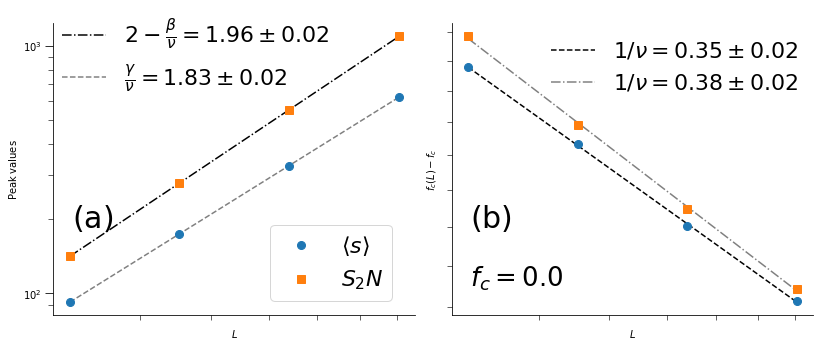

In [27]:
net_type = 'PDT'
param = 'param'
attack = 'Btw'
measures = [
    'meanS', 'Nsec', 
    #'varSgcc'
]

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlim(56, 340)
    #ax.set_xticks([64, 128, 256])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]

ax.text(0.05, 0.3, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):

    L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    

    if measure in ['meanS', 'varSgcc']:
        label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label1 = label
        line1, = ax.plot(L_values, Y_pred, '--', color='grey', label=label)


    elif measure == 'Nsec':
        label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label2 = label
        line2, = ax.plot(L_values, Y_pred, '-.', color='k', label=label)            

    markers1, = ax.plot(
        L_values, measure_values, marker_dict[measure], 
        color=color_dict[measure], markersize=8, 
        label=measures_dict[measure]
    )

handles, labels = ax.get_legend_handles_labels()
## Markers
order = [1, 3, 5][:len(measures)]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.6, 0.05))

ax.add_artist(legend1)
## Lines
order = [2, 0, 4][:len(measures)]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.0, 0.73), frameon=False)

#########################################################

dfs = {}
for N in sizes:
    print(N)
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

ax = axes[1]
fc = 0.0
ax.text(0.05, 0.3, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$f_c(L)-f_c$')
for i, measure in enumerate(measures):
        
    X = L_values
    Y, _ = getPeaks(dfs, measure)
    print(Y)
    Y = np.array(Y) - fc
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[0] / X[0]**slope
    label = r'$1/\nu = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err)
    ax.plot(X, Y_pred, linestyle_dict[measure], color=line_colors[measure], label=label)
    ax.plot(X, Y, marker_dict[measure], markersize=8, label=measures_dict[measure])
    
handles, labels = ax.get_legend_handles_labels()

## Lines
order = [0, 2, 4][:len(measures)]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.25, 0.73), frameon=False)

#ax.set_ylim(0.07, 0.13)
#ax.set_yticks([0.08, 0.1, 0.12])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.text(0.05, 0.1, r'$f_c={{{}}}$'.format(fc), fontsize=26, transform=ax.transAxes)    

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'beta_gamma_nu_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

1024
2048
4096
8192
16384
[0.21484375, 0.18798828125, 0.163818359375, 0.1475830078125]


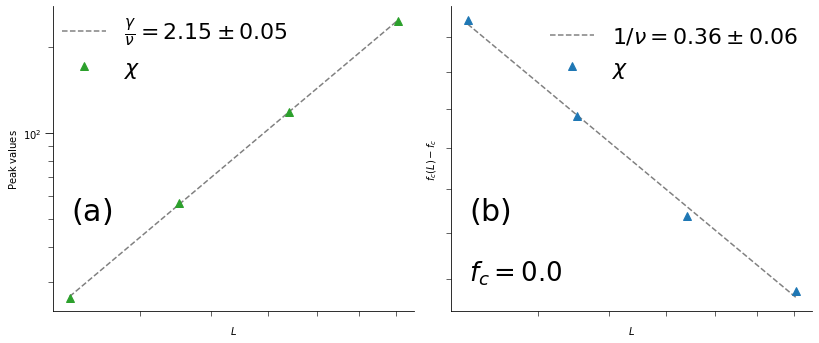

In [28]:
net_type = 'PDT'
param = 'param'
attack = 'Btw'
measures = ['varSgcc']

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlim(56, 340)
    #ax.set_xticks([64, 128, 256])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]

ax.text(0.05, 0.3, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):

    L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    

    if measure in ['meanS', 'varSgcc']:
        label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label1 = label
        line1, = ax.plot(L_values, Y_pred, '--', color='grey', label=label)


    elif measure == 'Nsec':
        label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label2 = label
        line2, = ax.plot(L_values, Y_pred, '-.', color='k', label=label)            

    markers1, = ax.plot(
        L_values, measure_values, marker_dict[measure], 
        color=color_dict[measure], markersize=8, 
        label=measures_dict[measure]
    )
ax.legend(fontsize=22, loc=(0.0, 0.73), frameon=False)

#########################################################

dfs = {}
for N in sizes:
    print(N)
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

ax = axes[1]
fc = 0.0
ax.text(0.05, 0.3, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$f_c(L)-f_c$')
for i, measure in enumerate(measures):
        
    X = L_values
    Y, _ = getPeaks(dfs, measure)
    print(Y)
    Y = np.array(Y) - fc
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[0] / X[0]**slope
    label = r'$1/\nu = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err)
    ax.plot(X, Y_pred, '--', color='grey', label=label)
    ax.plot(X, Y, marker_dict[measure], markersize=8, label=measures_dict[measure])
ax.legend(fontsize=22, loc=(0.25, 0.73), frameon=False)

#ax.set_ylim(0.07, 0.13)
#ax.set_yticks([0.08, 0.1, 0.12])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.text(0.05, 0.1, r'$f_c={{{}}}$'.format(fc), fontsize=26, transform=ax.transAxes)    

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'chi_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [29]:
net_type = 'PDT'
param = 'param'
attack = 'Btw'

sizes = np.array([
    256, 512, 1024, 2048, 4096, 8192,# 16384, 
    #32768, 65536, 131072, 262144
])
all_mean_values = []
all_std_values = []
nseeds_values = []
fluctuations = {}
for i, N in enumerate(sizes):
    try:
        delta_values, nseeds = load_delta(net_type, N, param, attack, min_nseeds=10, return_nseeds=True)
    except FileNotFoundError:
        print(N)
        raise
        
    nseeds_values.append(nseeds)
    
    delta_values[:,2] = delta_values[:,2]*N
    mean_values = delta_values.mean(axis=0)
    std_values = delta_values.std(axis=0)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    fluctuations[N] = delta_values - mean_values
    
all_mean_values = np.array(all_mean_values)
all_std_values = np.array(all_std_values)
nseeds_values = np.array(nseeds_values)

rc_values = all_mean_values[:,0]
delta_values = all_mean_values[:,1]

print(sizes, rc_values, delta_values)

[ 256  512 1024 2048 4096 8192] [0.27649258 0.24228437 0.21210244 0.18683159 0.16535372 0.14727933] [0.20325039 0.20530957 0.20531943 0.2051269  0.20412897 0.20447582]


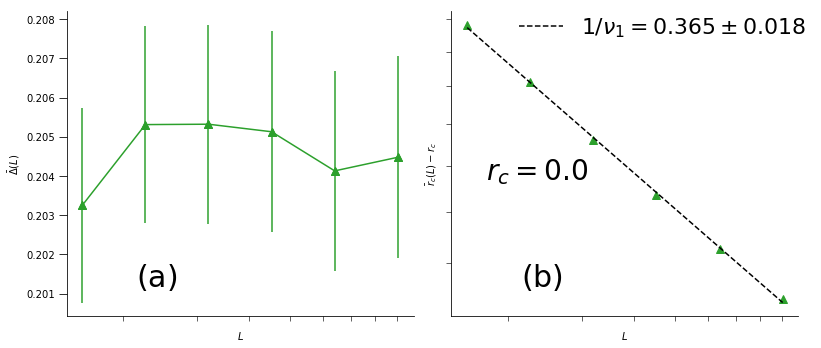

In [30]:
net_type = 'PDT'
param = 'param'
attack = 'Btw'
measures = ['meanS', 'Nsec']


ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]
#ax.set_xlim(30, 600)
#ax.set_xticks([32, 64, 128, 256, 512])
ax.text(0.2, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.3, 0.5])
#ax.set_yticks([0.39, 0.40, 0.41, 0.42])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\bar{\Delta}(L)$')

X = np.sqrt(sizes)
Y = all_mean_values[:,1]
Y_err = np.sqrt(all_std_values[:,1]/nseeds_values)

X = X
Y = Y
Y_err = Y_err

ax.plot(X, Y, '^', color='C2', markersize=8)
ax.errorbar(X, Y, Y_err, marker='^', color='C2', markersize=8)

ax = axes[1]
ax.set_yscale('log')
ax.text(0.2, 0.1, letters[1], transform=ax.transAxes, fontsize=30)

## rc = 0
#ax.set_ylim([0.048, 0.12])
#ax.set_yticks([0.05, 0.06, 0.07, 0.08, 0.09, 0.1])
#ax.set_yticks([0.04, 0.06, 0.08, 0.1, 0.12, 0.14])

## rc = 0.04
#ax.set_ylim([0.019, 0.06])
#ax.set_yticks([0.02, 0.03, 0.04, 0.05])

ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylabel(r'$\bar{r}_c(L) - r_c$')
rc = 0.00
X = np.sqrt(sizes)
Y = all_mean_values[:,0] - rc
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, '^', color='C2', markersize=8)
ax.plot(X, Y_pred, '--', color='k', label=r'$1/\nu_1={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err))
ax.legend(fontsize=22, loc=(0.17, 0.88), frameon=False)
#ax.set_xlim(30, 600)
#ax.set_xticks([32, 64, 128, 256, 512])
ax.text(0.1, 0.45, r'$r_c={{{}}}$'.format(rc), fontsize=28, transform=ax.transAxes)
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

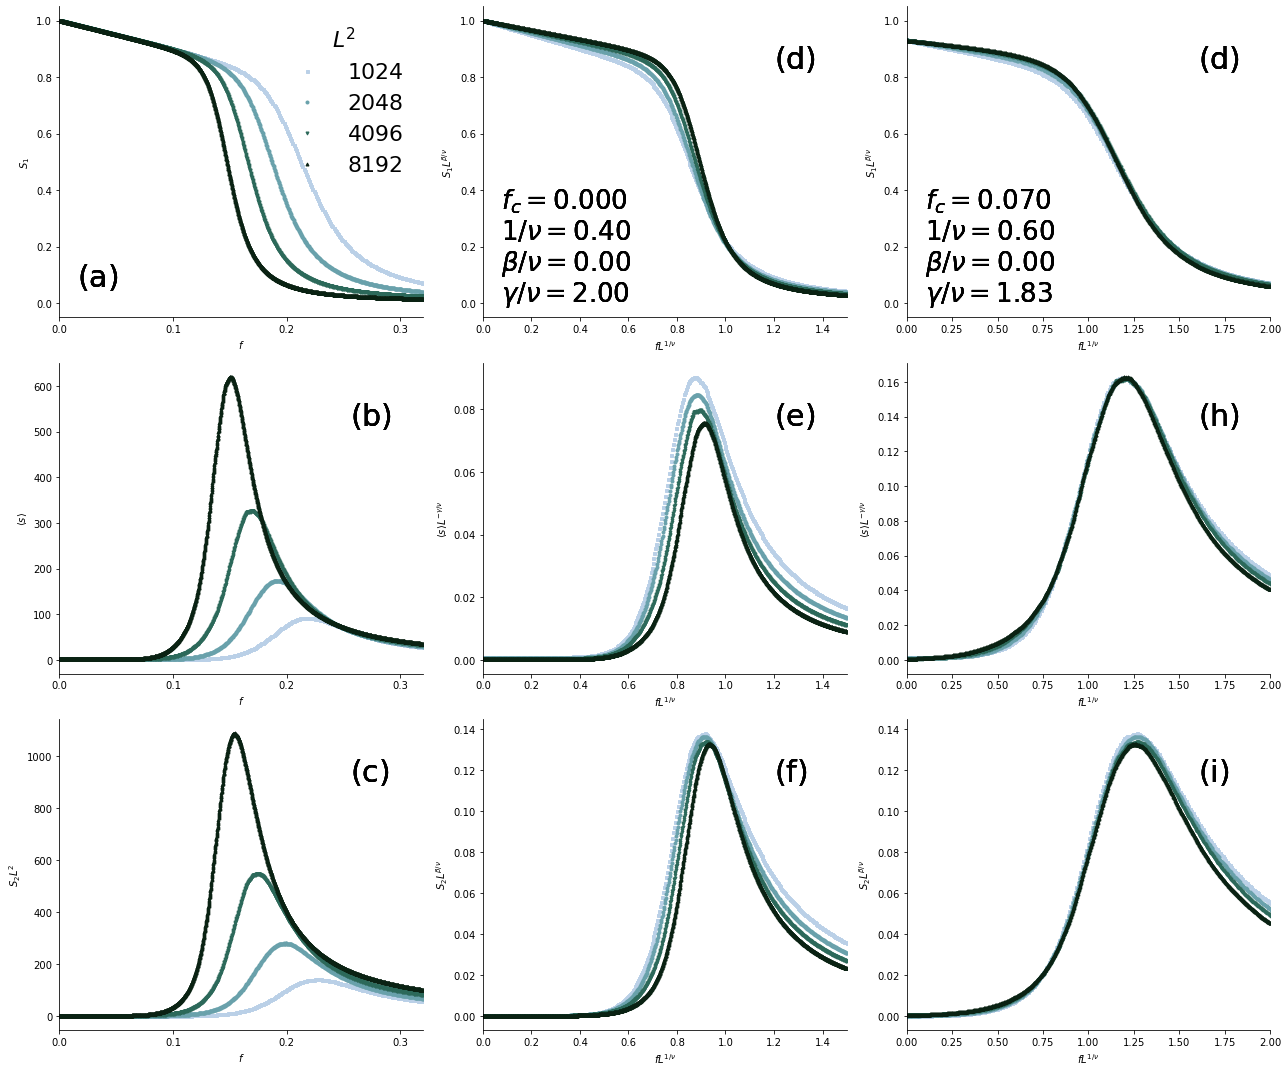

In [31]:
net_type = 'PDT'
param = 'param'
attack = 'Btw'
sizes = [1024, 2048, 4096, 8192]#, 16384, 32768, 65536]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 3
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
for ax in axes[:,0]:
    ax.set_xlim(0, 0.32)
    ax.set_xticks([0.0, 0.1, 0.2, 0.3])
    ax.set_xlabel(r'$f$')
for ax in axes[:,1]:
    ax.set_xlim(0, 1.5)
    ax.set_xlabel(r'$f L^{1/\nu}$')
for ax in axes[:,2]:
    ax.set_xlim(0, 2)
    ax.set_xlabel(r'$f L^{1/\nu}$')
    
ax = axes[0,0]
ax.set_ylabel(r'$S_1$')
ax = axes[1,0]
ax.set_ylabel(r'$\langle s\rangle$')
ax = axes[2,0]
ax.set_ylabel(r'$S_2L^2$')

for i in [1, 2]:
    ax = axes[0,i]
    ax.set_ylabel(r'$S_1 L^{\beta/\nu}$')
    ax = axes[1,i]
    ax.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$')
    ax = axes[2,i]
    ax.set_ylabel(r'$S_2 L^{\beta/\nu}$')
        
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    ax.text(0.05, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = axes[1,0]
    ax.text(0.8, 0.8, letters[1], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.meanS, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    ax = axes[2,0]
    ax.text(0.8, 0.8, letters[2], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.Nsec, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    
for j in [1, 2]:
    if j == 1:
        one_over_nu = 0.4
        gamma_over_nu = 2
        beta_over_nu = 0
        fc = 0.0
    else:
        one_over_nu = 0.6
        gamma_over_nu = 1.83
        beta_over_nu = 0.0
        fc = 0.07
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        L = np.sqrt(N)

        ax = axes[0,j]
        ax.text(0.8, 0.8, letters[3], transform=ax.transAxes, fontsize=30)

        ax.plot((df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
        ax.text(
            0.05, 0.35, r'$f_c = {{{:.3f}}}$'.format(fc), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.25, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.15, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.05, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), 
            transform=ax.transAxes, fontsize=26
        )

        ax = axes[1,j]
        ax.text(0.8, 0.8, letters[1+3*j], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )  

        ax = axes[2,j]
        ax.text(0.8, 0.8, letters[2+3*j], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.Nsec*L**(beta_over_nu-2), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )

legend = axes[0,0].legend(loc='upper right', fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [2]:
attack = 'Btw'

sizes = np.array([
    4096, 8192, 16384, 
    32768, 
    65536#,131072
                 ])
all_mean_values = []
all_std_values = []
nseeds_values = {}
fluctuations = {}
datas = {}
for i, N in enumerate(sizes):
    try:
        delta_data, nseeds = load_delta(net_type, N, param, attack, nseeds=10000, return_nseeds=True)
        nseeds_values[N] = nseeds
        data = delta_data#[:,1]
        #data = data - data.mean()
        datas[N] = data
    except FileNotFoundError:
        print(N)
        raise

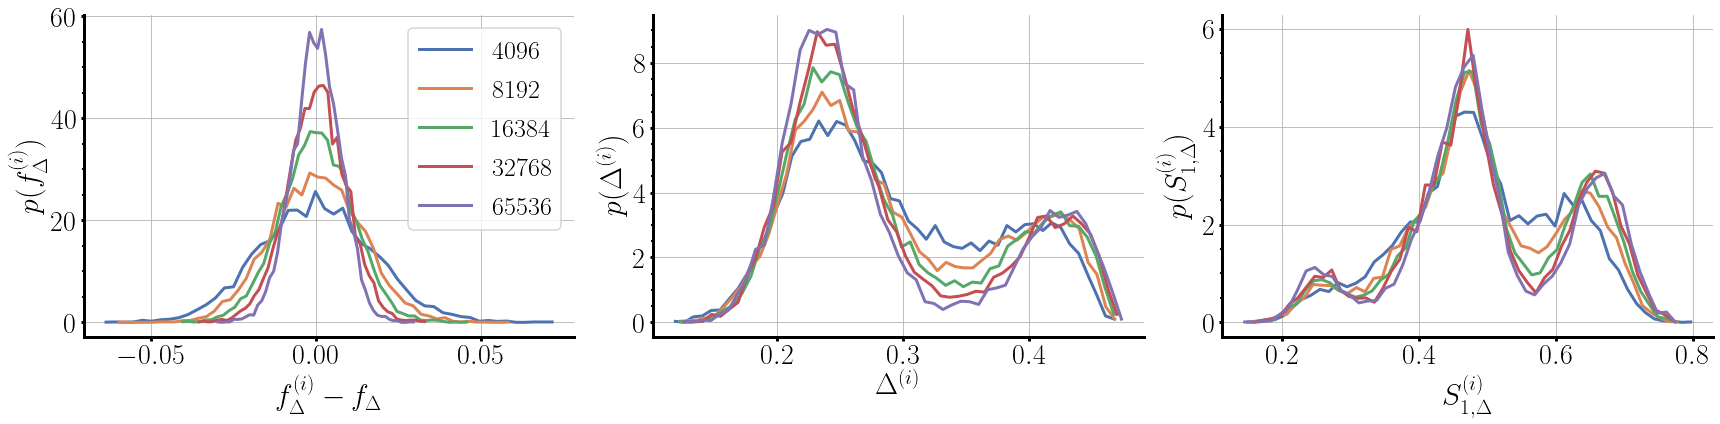

In [3]:
ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
ax = axes[0]
ax.set_ylabel(r'$p(f_{\Delta}^{(i)})$')
ax.set_xlabel(r'$f_{\Delta}^{(i)}-f_{\Delta}$')

ax = axes[1]
#ax.set_ylim(-10, 700)
#ax.set_xlim(0.1, 0.5)
ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_ylabel(r'$p(\Delta^{(i)})$')
ax.set_xlabel(r'$\Delta^{(i)}$')

ax = axes[2]
#ax.set_xlim(0.2, 1)
#ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
#ax.set_ylim(-10, 700)
ax.set_ylabel(r'$p(S_{1,\Delta}^{(i)})$')
ax.set_xlabel(r'$S_{1,\Delta}^{(i)}$')

for j in range(3):
    ax = axes[j]
    ax.grid(True)
    for N, data in datas.items():
        _data = data[:,j] if j != 0 else data[:,j] - data[:,j].mean()
        #if j == 2:
        #    _data = 1-_data-data[:,0]
        freq, bin_edges = np.histogram(_data, bins=50, density=True)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        label = r'${{{}}}$'.format(N) if j == 0 else ''
        ax.plot(bin_centers, freq, label=label)
        if j == 0:
            ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

# $$S_{1,\Delta}^{(i)} \leq 1-\Delta^{(i)}-f_{\Delta}^{(i)}$$

# $$\Delta^{(i)} \leq 1-S_{1,\Delta}^{(i)}-f_{\Delta}^{(i)}$$

In [69]:
Ngcc_values = [0, 1, 3, 9, 11][::-1]
delta_values = np.abs(np.diff(Ngcc_values))
max_pos = np.argmax(delta_values)
print(Ngcc_values[max_pos+1])
print(delta_values[max_pos])

3
6


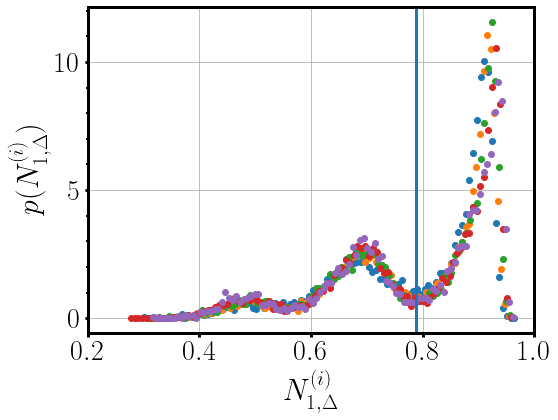

In [78]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax.set_xlim(0.2, 1)
ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(r'$p(N_{1,\Delta}^{(i)})$')
ax.set_xlabel(r'$N_{1,\Delta}^{(i)}$')
ax.grid(True)
for N, data in datas.items():
    _data = data[:,2]
    freq, bin_edges = np.histogram(_data, bins=100, density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    label = ''
    ax.plot(bin_centers, freq, 'o', label=label)
ax.axvline(_data.mean())
plt.show()

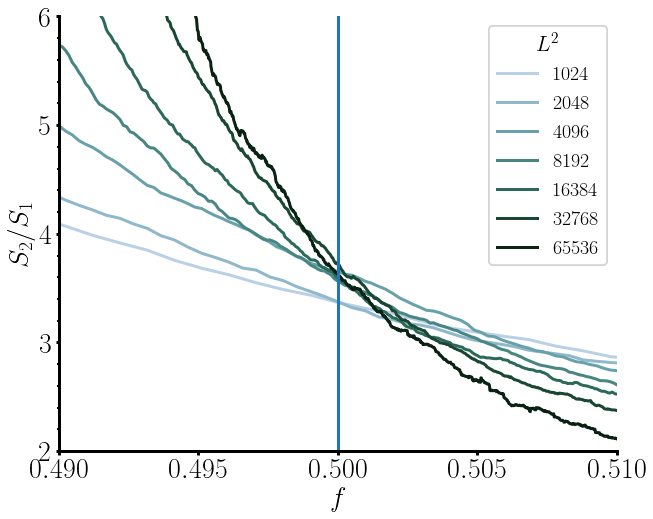

In [31]:
attack = 'Ran'
sizes = [
    1024, 2048, 4096, 8192, 16384, 32768, 65536,# 131072
]  

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, nseeds=10000)
    except FileNotFoundError:
        print(N)
        continue

N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colors = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, 
    light=0.8, dark=0.1
)

MIN = 1e-6
MAX = 1e-3
        
S2_over_S1 = {}
binder = {}
for N in N_values:
    df = dfs[N]        
    S1 = df.Sgcc
    S2 = df.Nsec / N
    
    S2_over_S1[N] = S2/S1
    
    mask = (S2_over_S1[N] < MIN) | (S2_over_S1[N] > MAX)
    S2_over_S1[N][mask] = np.NaN
    
    binder[N] = df.meanS_pow4 / df.meanS_pow2**2

fmin = 1e-4
fmax = 1e-1
ymin = 2e-6
ymax = 5e-4       

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(fmin, fmax)
#ax.set_ylim(ymin, ymax)
ax.set_xlim(0.49, 0.51)
ax.set_ylim(2, 6)
ax.set_ylabel(r'$S_2/S_1$', fontsize=28)
ax.set_xlabel(r'$f$', fontsize=28)

for i, N in enumerate(N_values):
    L = np.sqrt(N)
    #ax.axvline(1/L**1.3, linestyle=':', color='gray')
    df = dfs[N]

    label = r'${{{}}}$'.format(N) 
    ax.plot(
        df.f, binder[N], '-',
        color=colors[i], label=label
    )
        
handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles, labels,
          fontsize=20, loc='best')
legend1.set_title(r'$L^2$', prop={'size':22})
ax.add_artist(legend1)

ax.axvline(0.5)
sns.despine()

plt.show()

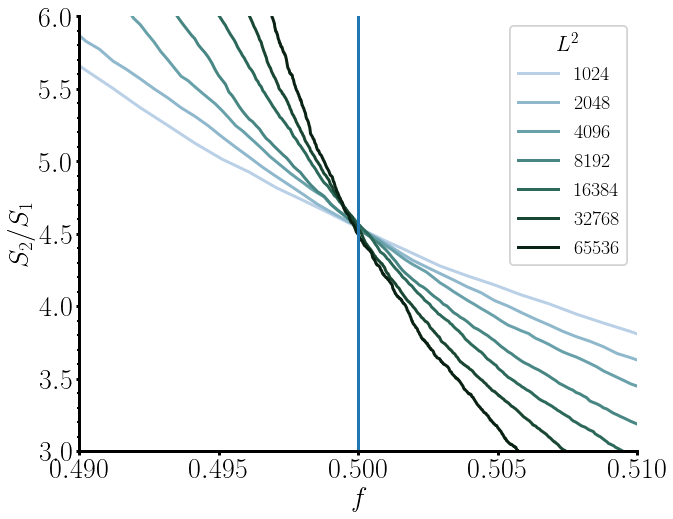

In [40]:
attack = 'Ran'
sizes = [
    1024, 2048, 4096, 8192, 16384, 32768, 65536,# 131072
]  

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, nseeds=10000)
    except FileNotFoundError:
        print(N)
        continue

N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colors = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, 
    light=0.8, dark=0.1
)

MIN = 1e-6
MAX = 1e-3
        
S2_over_S1 = {}
binder = {}
for N in N_values:
    df = dfs[N]        
    S1 = df.Sgcc
    S2 = df.Nsec / N
    
    S2_over_S1[N] = S2/S1
    
    mask = (S2_over_S1[N] < MIN) | (S2_over_S1[N] > MAX)
    #S2_over_S1[N][mask] = np.NaN
    
    binder[N] = df.meanS_pow4 / df.meanS_pow2**2

fmin = 1e-4
fmax = 1e-1
ymin = 2e-6
ymax = 5e-4       

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(fmin, fmax)
#ax.set_ylim(ymin, ymax)
ax.set_xlim(0.49, 0.51)
ax.set_ylim(3, 6)
#ax.set_ylim(0.2, 0.3)
ax.set_ylabel(r'$S_2/S_1$', fontsize=28)
ax.set_xlabel(r'$f$', fontsize=28)

for i, N in enumerate(N_values):
    L = np.sqrt(N)
    #ax.axvline(1/L**1.3, linestyle=':', color='gray')
    df = dfs[N]

    label = r'${{{}}}$'.format(N) 
    ax.plot(
        df.f, 1/S2_over_S1[N], '-',
        color=colors[i], label=label
    )
        
handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles, labels,
          fontsize=20, loc='best')
legend1.set_title(r'$L^2$', prop={'size':22})
ax.add_artist(legend1)

ax.axvline(0.5)
sns.despine()

plt.show()

In [25]:
from robustness.auxiliary import read_data_file, edgelist_to_adjlist
from robustness.percolation import percolate_fast, percolate_heap

In [31]:
net_type = 'DT'
param = 'param'
attack = 'Btw'
#size = 1048576
size = 131072
seed = 0
dir_name = NETWORKS_DIR / net_type
base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
base_net_dir = dir_name / base_net_name / base_net_name_size
network = f'{base_net_name_size}_{seed:05d}'
attack_dir_name = base_net_dir / network / attack

In [ ]:
edgelist = read_data_file(str(base_net_dir/network), network, reader='numpyInt')
adjlist = edgelist_to_adjlist(edgelist, size)
order = read_data_file(
    attack_dir_name, 'oi_list', reader='numpyInt'
)[::-1]

print('percolating')
perc_data = percolate_heap(adjlist, order)

In [27]:
df_perc = pd.DataFrame(perc_data)
df_perc['f'] = 1-df_perc['p']
df_perc['Sgcc'] = df_perc['N1'] / size

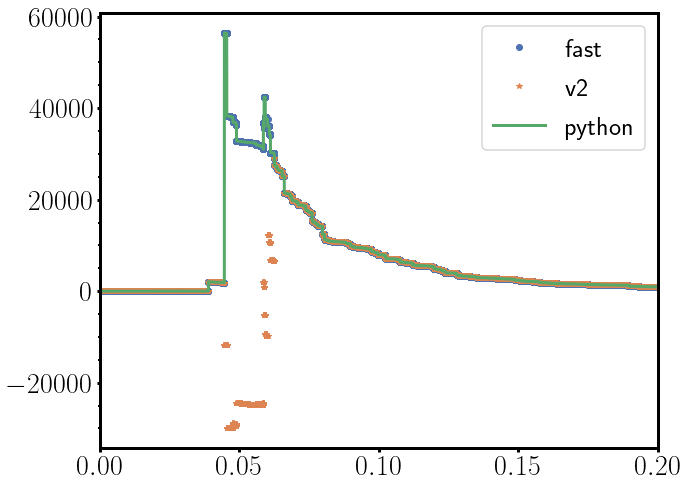

In [28]:
plt.figure(figsize=(10,8))
plt.xlim(0, 0.2)
_m = ['o', '*']
_labels = ['fast', 'v2']
X = np.arange(size)/size

for i, comp_data_file in enumerate(['comp_data', 'comp_data_v2']):
    data = read_data_file(
        str(attack_dir_name), comp_data_file, 
        reader='pandas', sep=' ', header=None
    ).values
    data = data[::-1]
    plt.plot(X, data[:,2], _m[i], label=_labels[i])
    
#plt.plot(X, np.array(perc_data['N1'])[::-1]/size, label='python')
plt.plot(X, np.array(perc_data['meanS'])[::-1], label='python')
plt.legend()
plt.show()

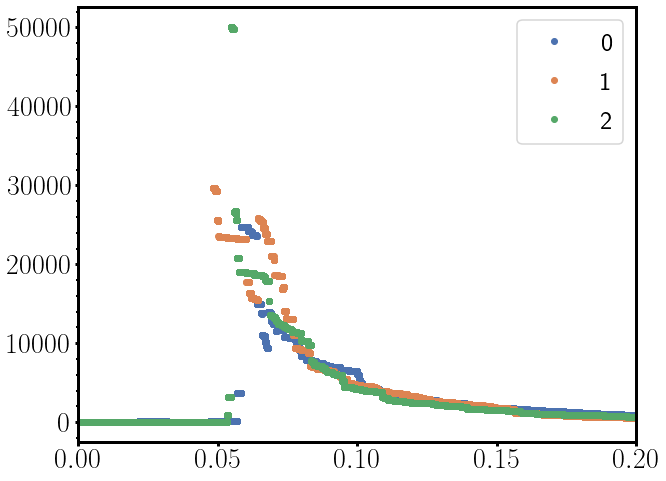

In [51]:
plt.figure(figsize=(10,8))
plt.xlim(0, 0.2)
_m = ['o', '*']
_labels = ['fast', 'v2']
X = np.arange(size)/size

seeds = range(3)
for seed in seeds:
    network = f'{base_net_name_size}_{seed:05d}'
    attack_dir_name = base_net_dir / network / attack
    for i, comp_data_file in enumerate(['comp_data']):
        data = read_data_file(
            str(attack_dir_name), comp_data_file, 
            reader='numpy'
        )
        data = data[::-1]
        #Y = data[:,5]*np.arange(size)-np.arange(size)
        Y = data[:,2]
        plt.plot(X, Y, _m[i], label=seed)
    
#plt.plot(X, np.array(perc_data['N1'])[::-1]/size, label='python')
#plt.plot(X, np.array(perc_data['meanS'])[::-1], label='python')
plt.legend()
plt.show()

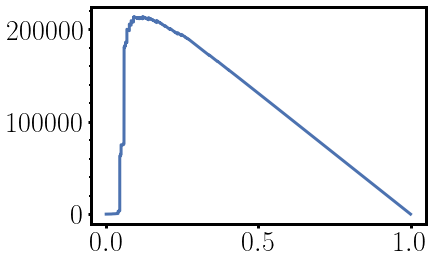

In [39]:
plt.plot(X, np.array(perc_data['denom'])[::-1], label='python')

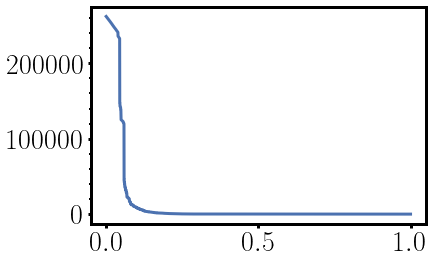

In [50]:
plt.plot(
    df_perc.f, 
    (df_perc['num'] + df_perc['N1']**2)/size
    #df_perc['num']/size
)

In [129]:
df = dfs[262144]
df.describe()

f           Sgcc        varSgcc           Nsec  \
count  262144.000000  262144.000000  262144.000000  262144.000000   
mean        0.499998       0.068648     142.965251    3573.345782   
std         0.288676       0.218670    1054.017478    8662.620326   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.249999       0.000109       0.000082      22.203509   
50%         0.499998       0.000906       0.007575     153.932456   
75%         0.749997       0.015812       1.461911    1952.680702   
max         0.999996       1.000000   11915.740806   53759.289474   

               meanS  chiDelta  
count  262144.000000  262144.0  
mean      541.325806       0.0  
std      1340.234865       0.0  
min         1.000000       0.0  
25%         3.430342       0.0  
50%        19.904741       0.0  
75%       212.770653       0.0  
max      8007.096456       0.0

In [23]:
nseeds_values = [1, 2, 5, 10]
for nseeds in nseeds_values:
    df = load_dataframe(net_type, size, param, attack, nseeds=nseeds)
    plt.plot(df.f, df.meanS)

FileNotFoundError: [Errno 2] No such file or directory: '/media/nahuel/E/E/dismantlingScaling/networks/DT/DT_param/DT_param_N131072/Btw_nSeeds1_cpp.csv'

In [10]:
net_type = 'DT'
param = 'param'
attack = 'Btw'
#size = 1048576
size = 131072
dir_name = NETWORKS_DIR / net_type
base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
base_net_dir = dir_name / base_net_name / base_net_name_size
network = f'{base_net_name_size}_{seed:05d}'
attack_dir_name = base_net_dir / network / attack

NameError: name 'seed' is not defined

In [35]:
attack = 'Btw'
sizes = [
    32768, 65536, 131072
]  

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, nseeds=10000)
    except FileNotFoundError:
        print(N)
        continue

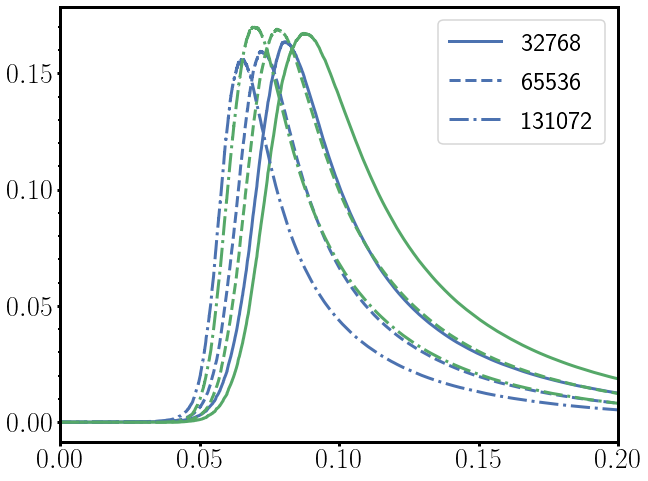

In [43]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(0, 0.2)
linestyles = ['-', '--', '-.', '..']
for i, N in enumerate(sizes):
    df = dfs[N]
    ax.plot(df.f, df.meanS/N, color='C0', linestyle=linestyles[i], label=N)
    #ax.plot(df.f, df.num / (df.denom*N), linestyle=linestyles[i], color='C1')
    ax.plot(df.f, 2*df.num/N**2, linestyle=linestyles[i], color='C2')
ax.legend()

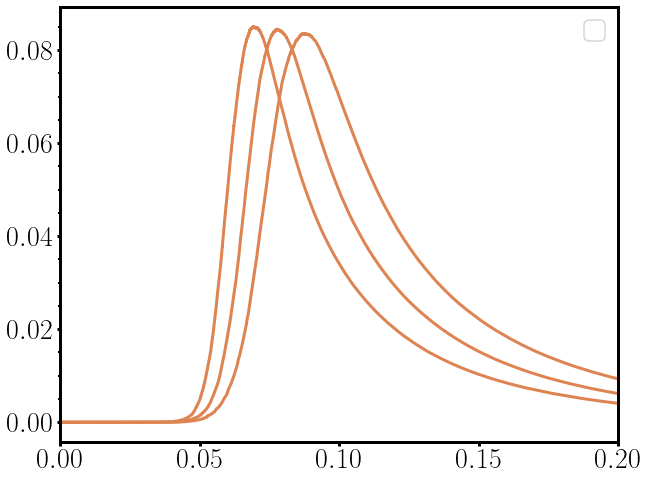

In [36]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(0, 0.2)
linestyles = ['-', '--', '-.', '..']
for i, N in enumerate(sizes):
    df = dfs[N]
    ax.plot(df.f, df.num/N**2, color='C1')
ax.legend()

In [46]:
attack = 'Btw'
sizes = [
    8192, 16384, 32768, 65536#, 131072
        ]
#sizes = [65536]
gcc = False

f_values_dict = {
    131072: ['0.06097', '0.06737', '0.06874'],
    65536: ['0.06786', '0.07231', '0.07579'],
    32768: ['0.07524', '0.08041', '0.08307'],
    16384: ['0.08338', '0.09088', '0.09326'],
    8192: ['0.09316', '0.10266', '0.10789']
}

all_comp_sizes = {}
nseeds_values = {}

for N in sizes:
    print(N)
    f_value = f_values_dict[N][1]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)
    if gcc:
        comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_gcc_{}_f{}_seeds.txt'.format(attack, f_value)
    else:
        comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_{}_f{}_seeds.txt'.format(attack, f_value)
    full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
    full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

    nseeds_values[N] = nseeds
    all_comp_sizes[N] = comp_sizes

print(nseeds_values)

8192
16384
32768
65536
{8192: 1000, 16384: 1000, 32768: 1000, 65536: 1000}


In [47]:
def loglog_histo(values, count, nbins):
    xmin = values.min()
    xmax = values.max()
    print(xmin, xmax)
    bin_edges = np.logspace(np.log10(xmin), np.log10(1.01*xmax), nbins+1)
    bin_edges
    freq = []
    for i in range(nbins):
        bin_width = bin_edges[i+1] - bin_edges[i]
        mask = (values>=bin_edges[i]) & (values<bin_edges[i+1])
        freq.append(count[mask].sum()/bin_width)
    freq = np.array(freq)
    #freq = freq/(freq*np.diff(bin_edges)).sum()
    freq[freq==0] = np.nan
    return freq, bin_edges

0.0001220703125 0.4427490234375
6.103515625e-05 0.4417724609375
3.0517578125e-05 0.44818115234375
1.52587890625e-05 0.45245361328125


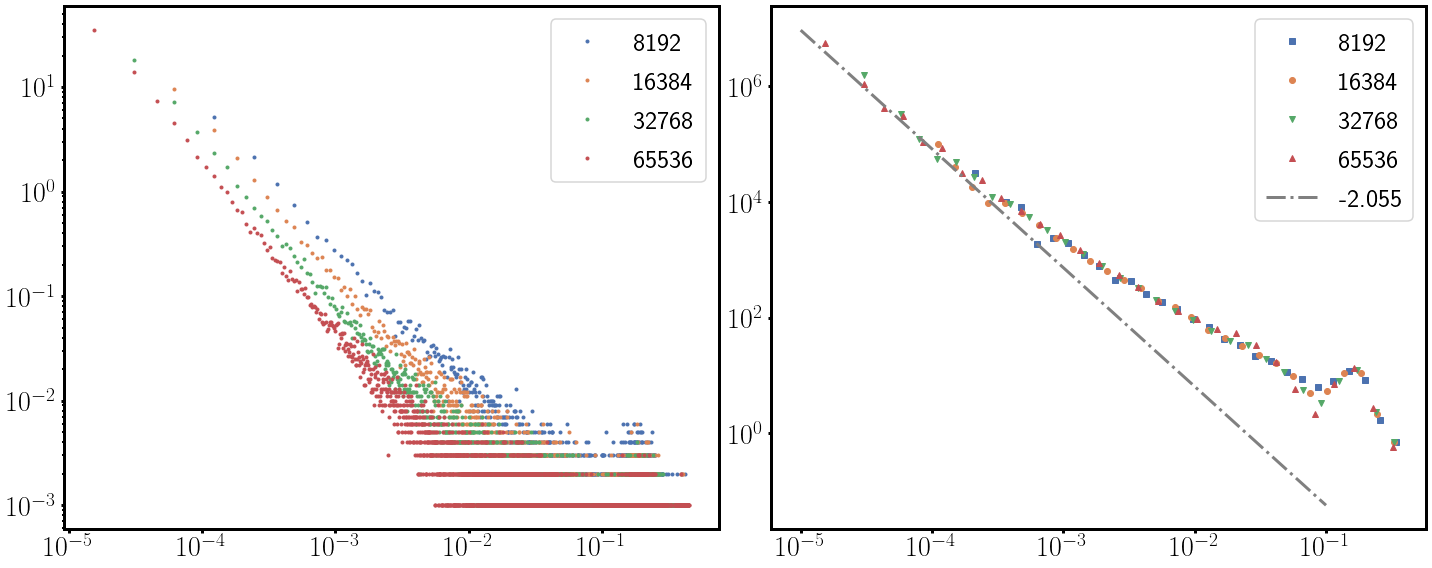

In [57]:
ncols = 2
fig, axes = plt.subplots(figsize=(10*ncols,8), ncols=2)
ax = axes[0]
ax.set_yscale('log')
ax.set_xscale('log')
for N, comp_sizes in all_comp_sizes.items():
    c_sizes, count = np.unique(comp_sizes, return_counts=True)
    count = count / nseeds_values[N]
    ns_values = c_sizes / N
    ax.plot(ns_values, count, '.', label=N)
ax.legend()

ax = axes[1]
ax.set_yscale('log')
ax.set_xscale('log')
for i, (N, comp_sizes) in enumerate(all_comp_sizes.items()):
    c_sizes, count = np.unique(comp_sizes, return_counts=True)
    count = count / nseeds_values[N]
    ns_values = c_sizes / N
    nbins = 30
    freq, bin_edges = loglog_histo(ns_values, count, nbins)
    ax.plot(bin_edges[:-1], freq, f'{markers[i]}', label=N)
X = [1e-5,1e-1]
slope = -1.4
#ax.plot(X, powerlaw(X, slope, 1e-1), color='k', linestyle='--', label=slope)

X = [1e-5,1e-1]
slope = -2.055
ax.plot(X, powerlaw(X, slope, 5e-4), color='gray', linestyle='-.', linewidth=3, label=slope)

ax.legend()

plt.tight_layout()
plt.show()

In [4]:
def get_rc_values(
    sizes, 
    l_values=None, 
    net_type='DT', 
    param='param', 
    nseeds=None, 
    min_nseeds=None,
    verbose=False, 
    base_attack='BtwU'
):

    if l_values is None:
        l_values = np.arange(2, 100)

    attacks = [base_attack] + [base_attack + f'_cutoff{l}' for l in l_values]
    rc_values = {}
    rc_values_std = {}
    for size in sizes:
        logger.info(size)
        rc_values[size] = []
        rc_values_std[size] = []
        for attack in attacks:
            try:
                delta_values = load_delta(
                    net_type, size, param, attack, 
                    nseeds=nseeds, min_nseeds=min_nseeds
                )
                rc = delta_values[:,0].mean(axis=0)
                rc_std = delta_values[:,0].std(axis=0) / np.sqrt(delta_values.shape[0])
                rc_values[size].append(rc)
                rc_values_std[size].append(rc_std)
            except FileNotFoundError:
                rc_values[size].append(np.NaN)
                rc_values_std[size].append(np.NaN)
            except IndexError:
                if verbose:
                    print(attack)
                rc_values[size].append(np.NaN)
                rc_values_std[size].append(np.NaN)
        rc_values[size] = np.array(rc_values[size])
        rc_values_std[size] = np.array(rc_values_std[size])

    return rc_values, rc_values_std

In [5]:
sizes=['512']
l_values = np.arange(2, 20)
net_type = 'DT'
param = 'param'
base_attack = 'Btw'
get_rc_values(sizes, l_values, net_type, param, base_attack=base_attack)

INFO: 06/29/2021 03:47:41 PM 512


({'512': array([0.1839127 , 0.28144922, 0.25858398, 0.24133203, 0.22728516,
         0.21570117, 0.20661914, 0.19943945, 0.19285156, 0.18900586,
         0.1852252 , 0.18293984, 0.18261484, 0.18339961, 0.18384707,
         0.1839084 , 0.1839127 , 0.1839127 ,        nan])},
 {'512': array([0.00035985, 0.00103877, 0.00121863, 0.00112007, 0.00111022,
         0.00108356, 0.00112682, 0.00112555, 0.00115649, 0.00036192,
         0.00036245, 0.00035984, 0.00035714, 0.00035803, 0.00035949,
         0.00035985, 0.00035985, 0.00035985,        nan])})

In [15]:
size = 512
nseeds = None
min_nseeds = None
def f():
    for l in range(200, 400):
        attack = f'Btw_cutoff{l}'
        try:
            load_delta(
                net_type, size, param, attack, 
                nseeds=nseeds, min_nseeds=min_nseeds
            )
        except FileNotFoundError:
            pass
    return
%timeit f() 

2.12 s ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [2]:
from pathlib import Path
from robustness import NETWORKS_DIR
from robustness.auxiliary import get_base_network_name

base_attack = 'Btw'
net_type = 'DT'
param = 'param'
min_nseeds = 1000
nseeds = None
threshold = 0.01
sizes = [
    4096, 
    8192, 16384, 32768, 65536, 131072
]

rc_values, rc_values_std = get_rc_values(
    net_type, param, base_attack, sizes, 
    nseeds=nseeds, min_nseeds=min_nseeds
)

INFO: 07/03/2021 10:43:49 AM NumExpr defaulting to 4 threads.


In [3]:
l_cutoff = get_l_cutoff(
    net_type, param,  base_attack, sizes, 
    threshold=threshold, rc_values=rc_values, 
    nseeds=nseeds, min_nseeds=min_nseeds
)

l_cutoff

{4096: 31, 8192: 42, 16384: 57, 32768: 78}

In [236]:
def get_right_node(v, L):
    if (v+1)%L == 0:
        return v+1-L
    return v+1

def get_upper_node(v, L):
    N = L*L
    if v+L >= N:
        return v+L-N
    return v+L

def get_upper_right_node(v, L):
    return get_upper_node(get_right_node(v, L), L)

def periodic_triangular_lattice_edgelist(L):
    N = L*L
    edgelist = []
    for y in range(L):
        for x in range(L):
            v = x + L*y
            edges_v = [
                (v, get_right_node(v, L)),
                (v, get_upper_node(v, L)),
                (v, get_upper_right_node(v, L))
            ]
            edges_v = [tuple(sorted(e)) for e in edges_v]
            edgelist += edges_v   
    return set(edgelist)

def triangular_lattice_positions(L):
    positions = []
    for y in range(L):
        if y%2 == 0:
            row = [(x, y) for x in range(L)]
        else:
            #row = [(x+0.5, y) for x in range(L)]
            row = [(x, y) for x in range(L)]
        positions += row
    positions = np.array(positions)
    return positions

def invert_diagonal(edgelist, s, L):
    t = get_upper_right_node(s, L)
    old_edge = (s, t)
    new_edge = (get_right_node(s, L), get_upper_node(s, L))
    if old_edge in edgelist:
        edgelist.remove(old_edge)
        edgelist.add(new_edge)
        
def invert_diagonals(edgelist, L, p):
    randomized_edgelist = set(edgelist)
    for s in range(L*L):
        r = np.random.rand()
        if r > p:
            invert_diagonal(randomized_edgelist, s, L)
    return randomized_edgelist

def triangular_lattice_graph(L, p=None):
    N = L*L
    g = ig.Graph()
    g.add_vertices(N)
    edgelist = periodic_triangular_lattice_edgelist(L)
    if p:
        edgelist = invert_diagonals(edgelist, L, p)
    g.add_edges(edgelist)
    return g

L = 100
g = triangular_lattice_graph(L, p=0.5)
g.summary()
print(g.degree_distribution())

N = 10000, mean +- sd: 6.0000 +- 0.9865
Each * represents 60 items
[4, 5): ********* (589)
[5, 6): ***************************************** (2504)
[6, 7): *************************************************************** (3819)
[7, 8): ***************************************** (2494)
[8, 9): ********* (594)


In [228]:
L = 20
N = L*L
p = 0.5
positions = triangular_lattice_positions(L)
edgelist = periodic_triangular_lattice_edgelist(L)
randomized_edgelist = invert_diagonals(edgelist, L, p)
M = len(edgelist)
print('m =', M)
print('k =', 2*M/N)
list(sorted(edgelist))
np.unique(np.unique(np.array(list(edgelist)).flatten(), return_counts=True)[1])

m = 1200
k = 6.0


array([6])

In [229]:
from matplotlib.collections import LineCollection

def is_non_periodic_link(s, t, L):
    return (
        ((t == s+1) and ((s+1)%L!=0)) or
        (t == s+L) or
        (t-1 == s+L) or
        (t-L == s-1)
    )

def is_periodic_link(s, t, L):
    return (
    
    )

lines = LineCollection(
    [
        (positions[s], positions[t]) for s, t in edgelist
        if is_non_periodic_link(s, t, L) 
    ]
)

randomized_lines = LineCollection(
    [
        (positions[s], positions[t]) for s, t in randomized_edgelist
        if is_non_periodic_link(s, t, L) 
    ]
)

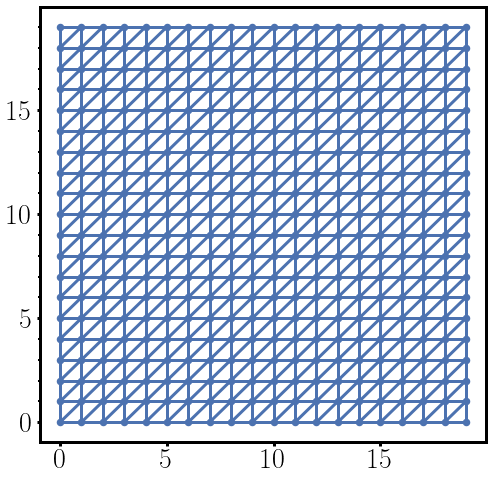

In [230]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(positions[:,0], positions[:,1])
ax.add_collection(lines)

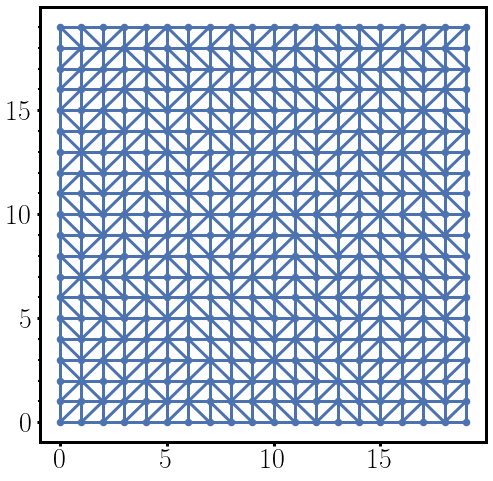

In [231]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(positions[:,0], positions[:,1])
ax.add_collection(randomized_lines)

In [42]:
net_type = 'DT'
param = 'param'
base_attack = 'Btw'
sizes = [
    4096, 8192, 16384, 
    32768, 65536
]
l_values = range(200)
attacks = [base_attack] + [f'{base_attack}_cutoff{l}' for l in l_values]
data = {}
for size in sizes:
    print(size)
    data[size] = {}
    for attack in attacks:
        try:
            df = load_dataframe(
                net_type, size, param, attack, 
                nseeds=None, min_nseeds=None
            )
        except FileNotFoundError:
            continue
        measure = 'Nsec'
        max_idx = df[measure].idxmax()
        #print(max_idx)
        fmax = df.iloc[max_idx].f
        data[size][attack] = fmax

4096
8192
16384
32768
65536


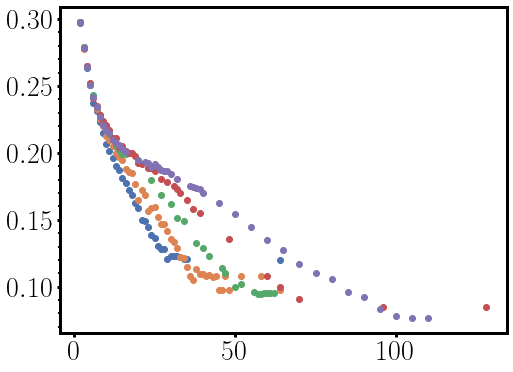

In [43]:
from robustness.plot_auxiliary import get_l_from_attack_name

fig, ax = plt.subplots(figsize=(8,6))
for size in sizes:
    fc = data[size][base_attack]
    l_values = [get_l_from_attack_name(attack) for attack in data[size].keys()]
    l_values = [elem for elem in l_values if ~np.isnan(elem)]
    X = np.array(l_values)
    Y = np.array([fc_l for attack, fc_l in data[size].items() if attack != base_attack])  

    ax.plot(X, Y, 'o')

plt.show()